# **Basic Well Log Interpretation**
Initial code from https://github.com/petroGG/Basic-Well-Log-Interpretation/tree/master<br>
Further developed by Afgha Izzam Tursina, Pahala Dominicus Sinurat, S.T, M.Sc., Ph.D., and Formation Evaluation Research Team (2022/2023)

# **0. Import Python Library**

In [3]:
# Plotting and Data Manipulation
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib import gridspec

# Statistics and Machine Learning
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

import scipy
from scipy.signal import savgol_filter   

import lasio.examples

# Other
import warnings
warnings.filterwarnings('ignore')


# **1. Change the Format and Combine Multiple Well Data**

### ***1.1. Function for changing the LAS file into TXT***

**Example of a normal LAS file:<br>**
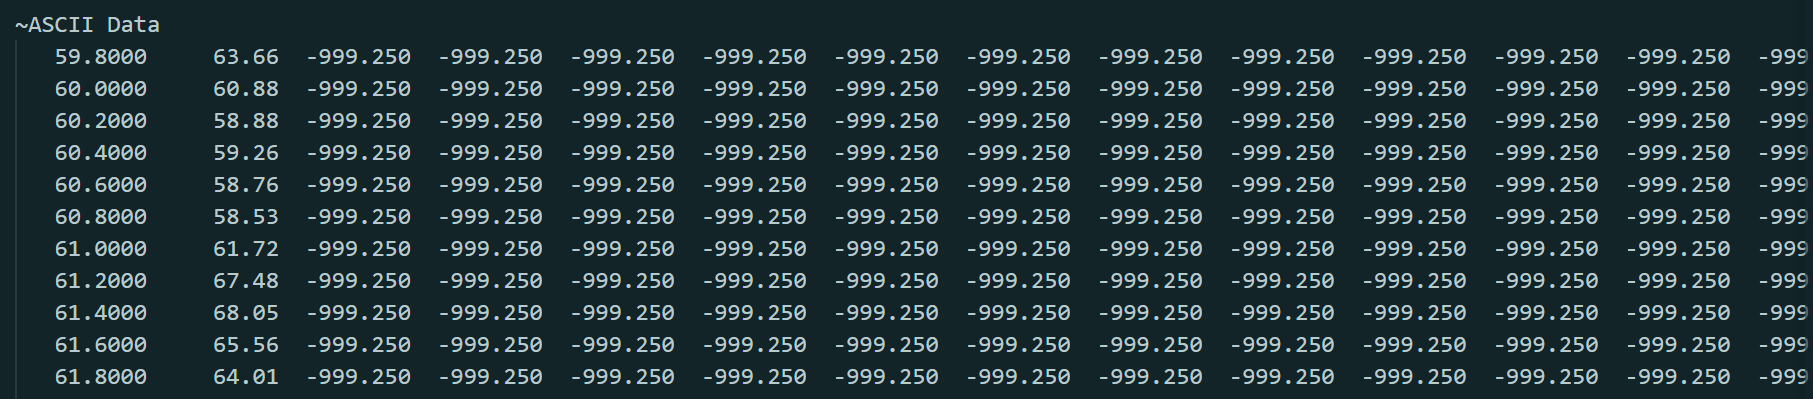

**Example of an abnormal LAS file:<br>**
If there are 24 data type curves, it should be distributed over 24 columns x 1 row, but in this example it is distributed over 7 columns x 5 row. 

***So curve information rows = 5*** <br>

Example of a abnormal LAS file:
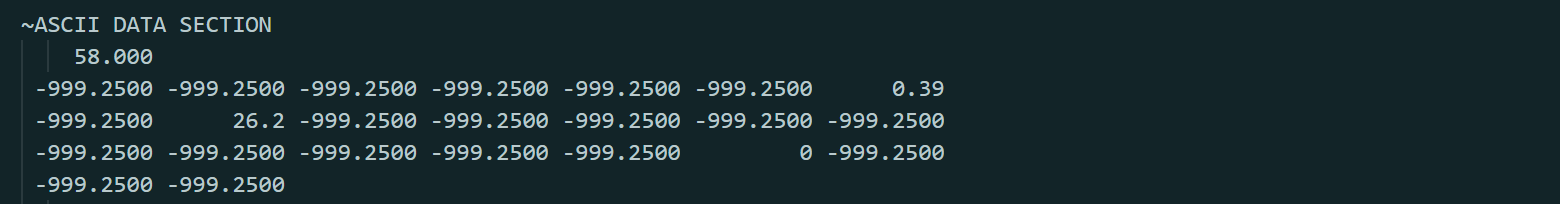


### ***1.2. Convert LAS files into TXT***


#### **1.2.1 Column name adjustments for each well** <br>
Do a rename for columns that don't match the sourcecode. For data columns that are intended to be plotted, they must match as follows:

**Traject 1: GR, CALI, SP**
- GR (Gamma Ray): Gamma ray logging measures the natural radioactivity of the formation. It is useful for differentiating between shale and non-shale rock types since shale typically has a higher gamma ray signature. It's commonly used for correlation and stratigraphic interpretation.
- CALI (Caliper): Caliper logs measure the borehole diameter. They are used to assess the quality of the borehole, identify washouts, and help correct other logs for borehole size effects.
- SP (Spontaneous Potential): The SP log measures the naturally occurring electrical potential difference between the borehole fluid and the formation. It's often used to detect permeable zones, clay boundaries, and stratigraphic changes.

**Traject 2: DR, MR, SR**
- Deep Resistivity (DR), Medium Resistivity (MR), Shallow Resistivity (SR): These resistivity logs  measure the electrical resistivity of the formation at different depths of investigation. They are essential for determining formation water saturation, porosity, and lithology. The deep resistivity log is less affected by invasion of drilling mud, while the shallow resistivity log is more influenced by invasion. There are many tools for measuring resistivity, such as: induction logging tools, laterolog logging tools, microsfl, HDR, Array, etc.

**Traject 3: RHOB, NPHI, DT**
- NPHI (Neutron Porosity): The neutron porosity log measures the hydrogen index of the formation. This is used to estimate porosity by quantifying the amount of hydrogen in the formation, which is indicative of pore space.
- DT (Delta-T or Transit Time): The DT log measures the time it takes for acoustic waves to travel through the formation. It is used to calculate formation porosity and can also help identify lithology changes.
- RHOB (Bulk Density): The bulk density log measures the density of the formation. It's used to estimate porosity, differentiate between rock types, and calculate mineral composition.

In [4]:
#Read Lasio data file with lasio.example library
file_name = "ll-4_wire_lima.las"
data = lasio.read(file_name).df().reset_index()

# Rename multiple columns
data = data.rename(columns={'DEPTH': 'DEPT', 'RT': 'DR', 'ILM': 'MR', 'LLS': 'SR', 'NPHI_CORR': 'NPHI'})

data['WELL'] = 'LL4'

# Keep only the specified columns
columns_to_keep = ["DEPT", "CALI", "DT", "GR", "MR", "DR", "SR", "NPHI", "RHOB", "SP", "VSH", "RW", "WELL"]
data = data.filter(columns_to_keep)


data.head()

Only engine='normal' can read wrapped files


DEPT  CALI  DT  GR  MR  DR  SR  NPHI  RHOB  SP  VSH        RW WELL
0   0.0   NaN NaN NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205728  LL4
1   0.5   NaN NaN NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205695  LL4
2   1.0   NaN NaN NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205662  LL4
3   1.5   NaN NaN NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205629  LL4
4   2.0   NaN NaN NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205596  LL4

In [5]:
data["WELL"].unique()

array(['LL4'], dtype=object)

# **2. Functions for Data Distribution Plots**

In [6]:
columns_to_plot = ["CALI", "DT", "GR", "MR", "DR", "SR", "NPHI", "RHOB", "SP"]
columns_unit = ["in", "us/ft", "API", "ohm.m", "ohm/m", "ohm.m", "v/v", "g/cm³", "mV"]

### ***2.1. Data distribution based on Box Plot***

In [7]:
def boxplot(data):
    # Define the list of columns you want to create subplots for
    columns = columns_to_plot #["GR", "CALI", "SP", "DR", "MR", "SR", "NPHI", "RHOB", "DT"]
    units = columns_unit #["in", "API", "mV", "ohm/m", "ohm.m", "ohm.m", "v/v", "g/cm³", "us/ft"]

    # Get unique wells and assign colors
    wells = data['WELL'].unique()
    colors = sns.color_palette('viridis', n_colors=len(wells))

    # Set the figure size for the overall plot
    plt.figure(figsize=(16, 12))

    # Create subplots for each selected column
    for i, column in enumerate(columns, 1):
        plt.subplot(3, 3, i)  # Create a 3x3 grid of subplots
        
        # Plot boxplots for each well with different colors
        for well, color in zip(wells, colors):
            well_data = data[data['WELL'] == well]
            sns.boxplot(x=well_data[column], y=data["WELL"], color=color)
        
        plt.title(f'Boxplot for {column}', fontsize=12)  # Set the title for the subplot
        plt.xlabel(f'{column} [{units[i-1]}]', fontsize=10)  # Set the x-axis label with the corresponding unit
        plt.ylabel('Frequency', fontsize=10)  # Set the y-axis label as 'Frequency'

    # Add an overall title for the set of subplots
    plt.suptitle("DATA DISTRIBUTION (BOX PLOT)\n", fontsize=16, fontweight='bold')

    # Create a custom legend outside the subplots
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=well, markerfacecolor=color, markersize=10) for well, color in zip(wells, colors)]
    plt.legend(handles=legend_handles, title='WELL', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()



### ***2.2. Data distribution based on Histogram Plot***

In [8]:
def histplot(data):
    # Get unique wells and assign colors
    wells = data['WELL'].unique()
    colors = sns.color_palette('viridis', n_colors=len(wells))

    # Create subplots for histograms
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    fig.suptitle('DATA DISTRIBUTION (HISTOGRAM PLOT) \n', fontsize=14, fontweight='bold')
    fig.subplots_adjust(top=0.95, wspace=0.3, hspace=0.3)

    # List of columns and their corresponding units
    columns = columns_to_plot
    units = columns_unit

    for i, ax in enumerate(axes.flat):
        if i < len(columns):
            column_name = columns[i]
            column_unit = units[i]  # Specify the unit for the column
            ax.set_title(column_name)
            
            # Plot histograms for each well with different colors
            for well, color in zip(wells, colors):
                well_data = data[data['WELL'] == well]
                sns.histplot(well_data[column_name].dropna(), bins=50, color=color, ax=ax, kde=True, label=well)
            
            ax.set_xlabel(f"{column_name} [{column_unit}]")  # Include the specified unit in the x-axis label
            ax.legend(title='WELL')

    # Remove empty subplots if there are more plots than columns
    if len(columns) < len(axes.flat):
        for i in range(len(columns), len(axes.flat)):
            fig.delaxes(axes.flat[i])

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()


### ***2.3. Data distribution based on Density Plot***

In [9]:
def densityplot(data):
    wells = data['WELL'].unique()
    colors = sns.color_palette('viridis', n_colors=len(wells))  # Add this line
    
    # Group the data by 'WELL' and create subplots
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    fig.suptitle('DATA DISTRIBUTION (DENSITY PLOT)\n', fontsize=16)
    fig.subplots_adjust(top=0.95, wspace=0.3, hspace=0.3)
    
    # List of columns and their corresponding units
    columns = columns_to_plot
    units = columns_unit

    for i, ax in enumerate(axes.flat):
        if i < len(columns):
            column_name = columns[i]
            column_unit = units[i]  # Specify the unit for the column
            ax.set_title(column_name)
            
            # Plot density plots for each well with different colors
            for well, color in zip(wells, colors):
                well_data = data[data['WELL'] == well]
                well_data[column_name].plot(kind='kde', ax=ax, label=well, color=color)
            
            ax.set_xlabel(f"{column_name} [{column_unit}]")  # Include the specified unit in the x-axis label
            ax.set_ylabel("Frequency")
            ax.legend(title='WELL')

    # Remove any remaining empty subplots
    if len(columns) < len(axes.flat):
        for i in range(len(columns), len(axes.flat)):
            fig.delaxes(axes.flat[i])

    plt.tight_layout()
    plt.show()


### ***2.4. Data distribution based on Cross Plot***

In [10]:
def crossplott(logs,x,y,c,x_label,y_label,c_label):
    def scatter_hist(x, y, c, ax, ax_histx, ax_histy, ax_cbar, x_name, y_name, c_name, x_label, y_label, c_label):
        ax_histx.tick_params(axis="x")
        ax_histy.tick_params(axis="y")
        
        # Remove NaN values from the data
        valid_data_mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(c)
        x = x[valid_data_mask]
        y = y[valid_data_mask]
        c = c[valid_data_mask]
        
        points = ax.scatter(x, y, c=c, s=50,cmap="viridis", alpha=0.8, edgecolors="none")
        cbar = plt.colorbar(points, cax=ax_cbar)
        
        bins = 100
        
        # Create a histogram for x and set the color based on values in column C
        hist_x, edges_x = np.histogram(x, bins=bins)
        
        # Create a colormap for gradient colors based on column C
        norm_x = plt.Normalize(c.min(), c.max())
        cmap_x = plt.get_cmap("viridis")
        
        for i in range(len(edges_x) - 1):
            mask = (x >= edges_x[i]) & (x < edges_x[i+1])
            ax_histx.bar([edges_x[i]], [np.sum(mask)], width=np.diff(edges_x)[i], color=cmap_x(norm_x(c[mask])))
        
        # Create a histogram for y and set the color based on values in column C
        hist_y, edges_y = np.histogram(y, bins=bins)
        
        # Create a colormap for gradient colors based on column C
        norm_y = plt.Normalize(c.min(), c.max())
        cmap_y = plt.get_cmap("viridis")
        
        for i in range(len(edges_y) - 1):
            mask = (y >= edges_y[i]) & (y < edges_y[i+1])
            ax_histy.barh([edges_y[i]], [np.sum(mask)], height=np.diff(edges_y)[i], color=cmap_y(norm_y(c[mask])))
        
        ax.invert_yaxis()
        ax_histy.invert_yaxis()
        
        ax.set_xlabel(f'{x_name} [{x_label}]')
        ax.set_ylabel(f'{y_name} [{y_label}]')
        
        ax_histx.set_xlabel(f'{x_name} [{x_label}]')
        ax_histx.set_ylabel(f'{c_name} [{c_label}]')
        ax_histx.set_yticks([])
        
        ax_histy.set_ylabel(f'{y_name} [{y_label}]')
        ax_histy.set_xlabel(f'{c_name} [{c_label}]')
        ax_histy.set_xticks([])
        
        ax_cbar.set_title(f'{c_name} [{c_label}]', fontsize=10)
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(f'{x} - {y} Crossplot'.upper(), fontsize=14, fontweight='bold')
    fig.subplots_adjust(top=0.95, wspace=0.01, hspace=0.01)

    gs = fig.add_gridspec(2, 3, width_ratios=(0.1, 9, 0.9), height_ratios=(1, 9))

    # Create the axes
    ax = fig.add_subplot(gs[1, 1])
    ax_histx = fig.add_subplot(gs[0, 1], xticklabels=[])
    ax_histy = fig.add_subplot(gs[1, 2], yticklabels=[])
    ax_cbar = fig.add_subplot(gs[1, 0])

    # Replace 'logs.NPHI' and 'logs.RHOB' with 'x' and 'y' as you pass these as function arguments
    scatter_hist(logs[x], logs[y], logs[c], ax, ax_histx, ax_histy, ax_cbar, x, y, c, x_label, y_label, c_label)

    # Finally, show the plot
    plt.tight_layout()
    plt.show()


### ***2.5. Data Distribution Example***

#### **2.5.1. Original Data Distribution (With NaN Value)** <br>

In [11]:
data.describe()

DEPT          CALI           DT            GR            MR  \
count  13981.000000  10394.000000  9615.000000  10390.000000  10374.000000   
mean    3495.000000     12.115885   107.581031     63.907625      2.312847   
std     2018.055696      3.027074    24.303341     27.017865      3.298621   
min        0.000000      0.000000     0.000000      9.900000      0.200600   
25%     1747.500000      9.460000    89.500000     42.062500      0.717725   
50%     3495.000000     12.340000   108.550000     64.720000      0.932550   
75%     5242.500000     12.740000   122.100000     79.400000      2.450075   
max     6990.000000     22.270000   191.061000    176.800000     46.344700   

                 DR           SR         NPHI         RHOB            SP  \
count  10440.000000  1210.000000  9184.000000  9314.000000  10394.000000   
mean       3.093636     0.835083     0.420528     2.296849     19.632336   
std        8.397807     0.480027     0.097965     0.191633     56.193522   
min        0.330000     0.174200     0.038000     1.210000   -129.000000   
25%        0.802975     0.591600     0.363900     2.182900    -37.100000   
50%        1.040000     0.688700     0.431500     2.287200     17.950000   
75%        2.852450     0.851100     0.487025     2.420000     73.800000   
max      249.379000     2.992300     0.813700     2.770000    121.100000   

               VSH            RW  
count  4679.000000  13981.000000  
mean      0.561747      0.107826  
std       0.340048      0.037525  
min       0.000000      0.063355  
25%       0.233600      0.076609  
50%       0.641300      0.096876  
75%       0.868800      0.131724  
max       1.000000      0.205728

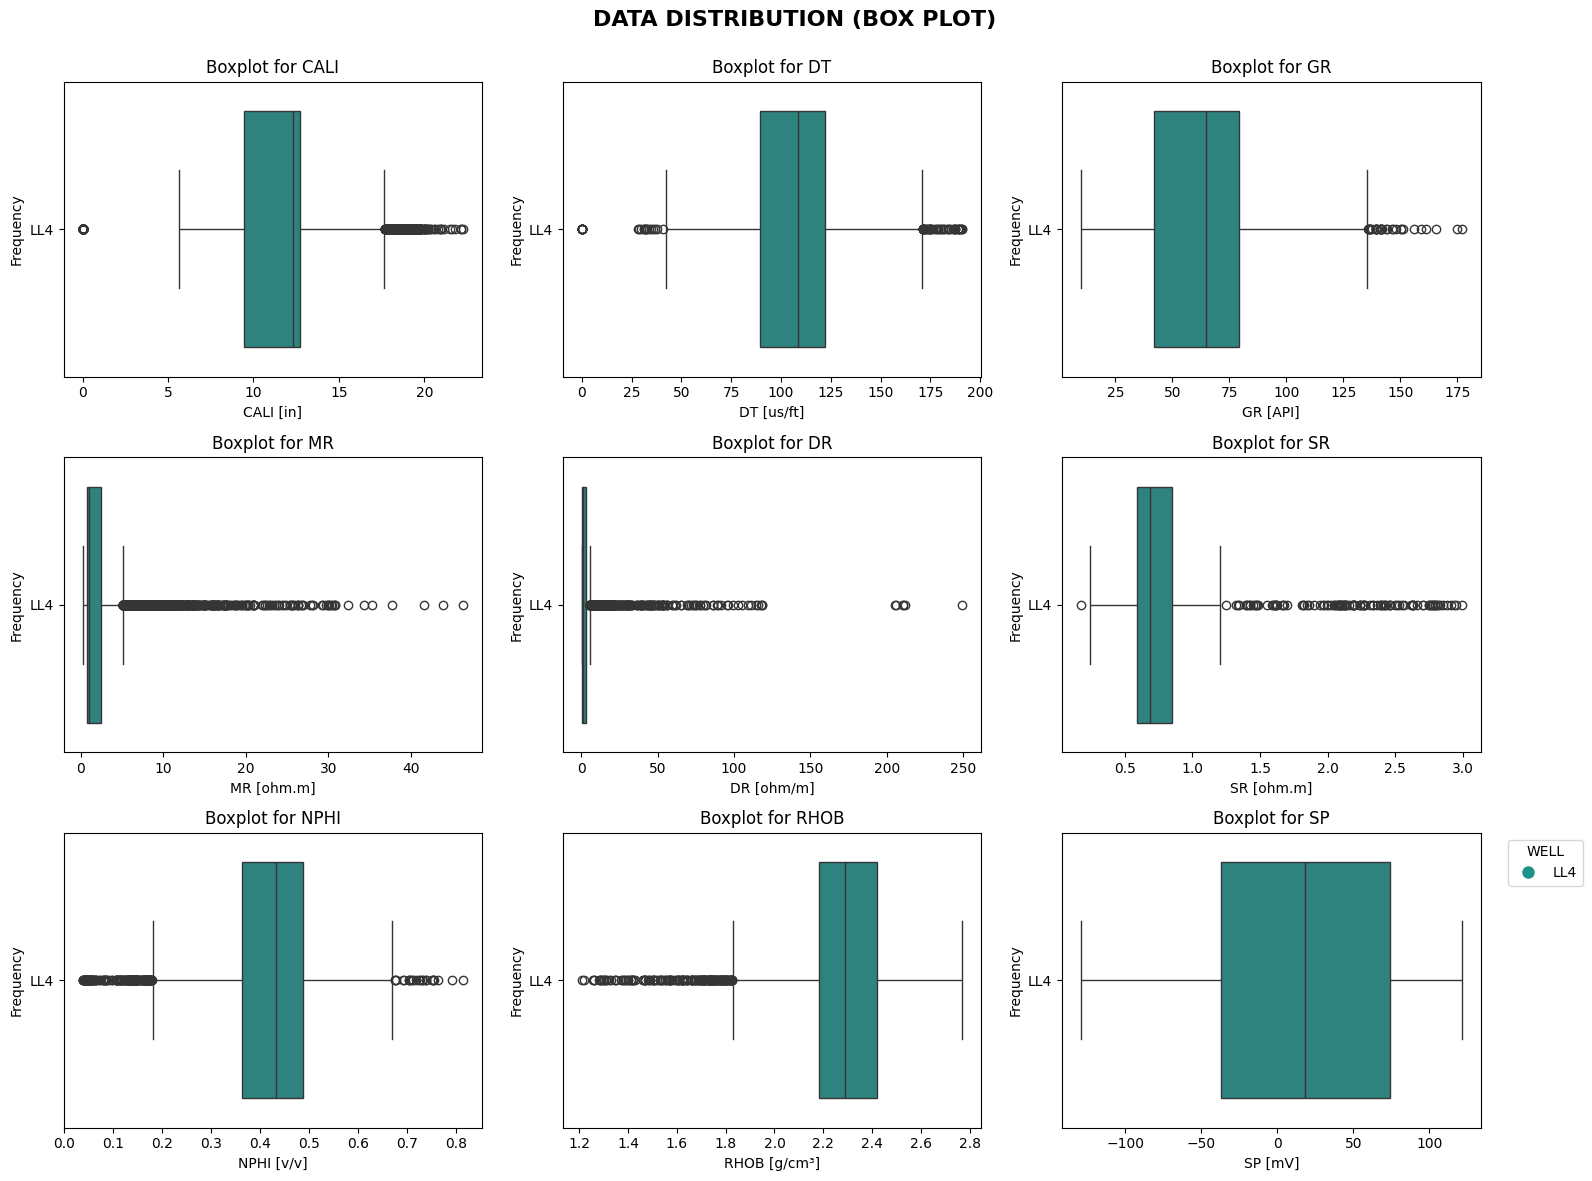

In [12]:
boxplot(data)

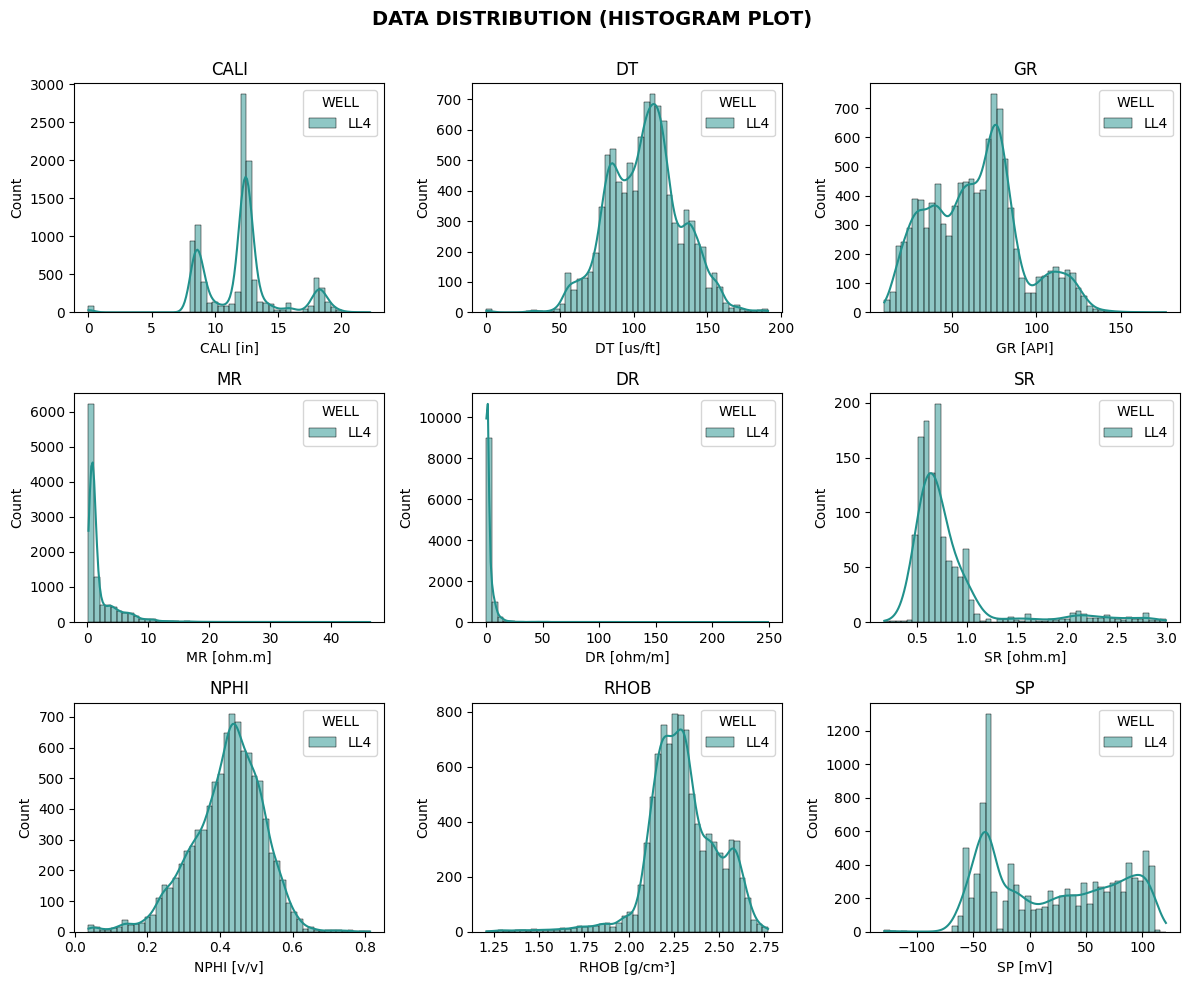

In [13]:
histplot(data)

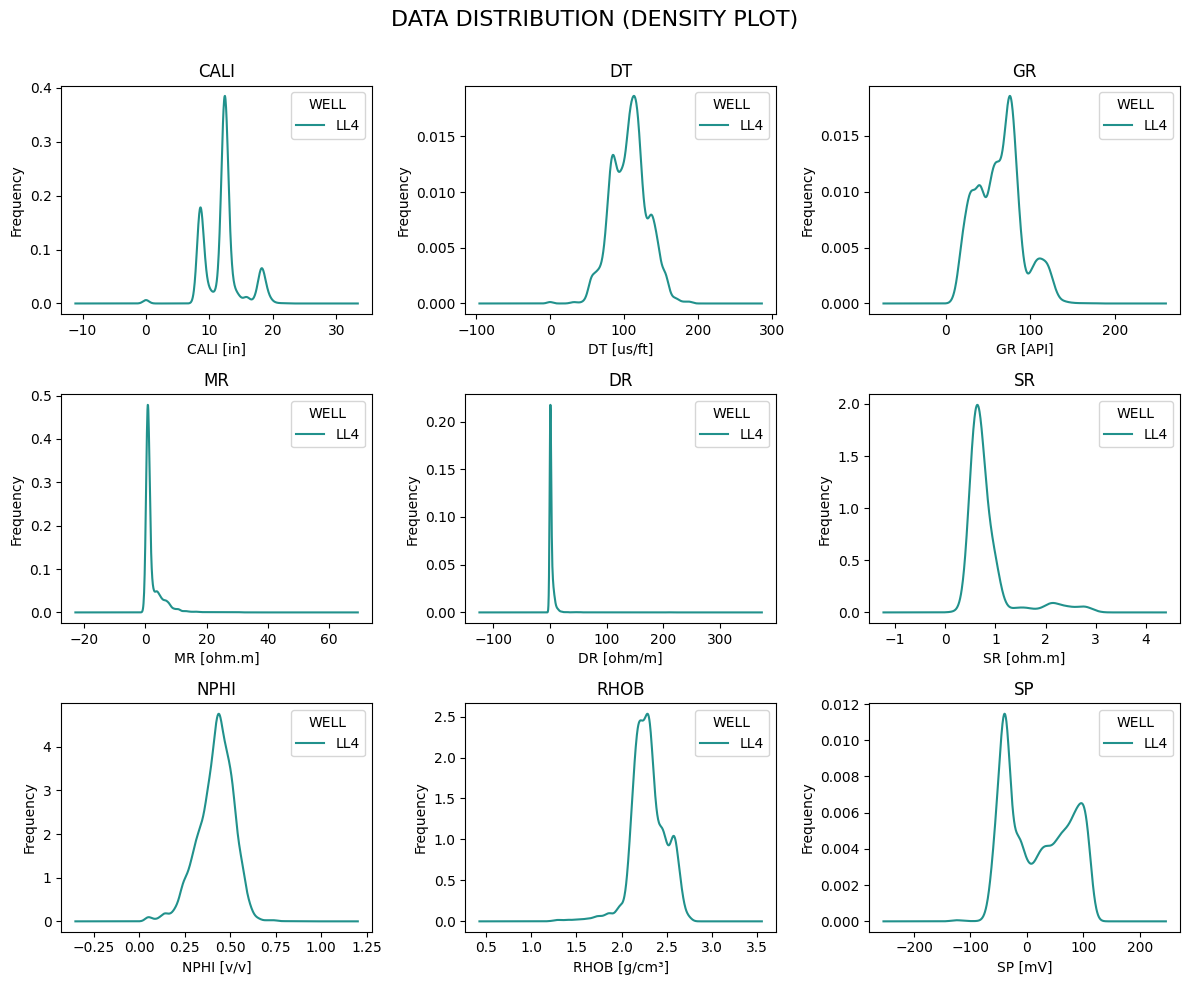

In [14]:
densityplot(data)

# **3. Outlier Handling (If Needed)**

In [15]:
def nan_handler(data, handler):
    numeric_cols = data.select_dtypes(include=['number']).columns
    if handler == "mean":
        data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
        save_name = "data_clean_mean.txt"
    elif handler == "median":
        data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())
        save_name = "data_clean_median.txt"
    elif handler == "zero":
        data[numeric_cols] = data[numeric_cols].fillna(0)
        save_name = "data_clean_zeros.txt"
    else :
        save_name = "data_clean_NaN.txt"
        data[numeric_cols] = data[numeric_cols].fillna(-999.25)
    return data, save_name

In [16]:
handler = "nan"
handled_data, data_name = nan_handler(data, handler)

In [17]:
data = handled_data

data.describe()

DEPT          CALI            DT            GR            MR  \
count  13981.000000  13981.000000  13981.000000  13981.000000  13981.000000   
mean    3495.000000   -247.362652   -238.061218   -209.162901   -256.083347   
std     2018.055696    441.723213    513.345899    465.088587    438.238798   
min        0.000000   -999.250000   -999.250000   -999.250000   -999.250000   
25%     1747.500000   -999.250000   -999.250000   -999.250000   -999.250000   
50%     3495.000000     12.030000     91.492000     50.960000      0.780500   
75%     5242.500000     12.560000    115.767000     75.460000      1.411200   
max     6990.000000     22.270000    191.061000    176.800000     46.344700   

                DR            SR          NPHI          RHOB            SP  \
count  13981.00000  13981.000000  13981.000000  13981.000000  13981.000000   
mean    -250.77224   -912.696610   -342.574932   -332.029676   -241.774641   
std      435.98075    281.202669    474.607927    472.319207    447.628206   
min     -999.25000   -999.250000   -999.250000   -999.250000   -999.250000   
25%     -999.25000   -999.250000   -999.250000   -999.250000   -999.250000   
50%        0.86000   -999.250000      0.359300      2.181900    -32.800000   
75%        1.69000   -999.250000      0.455300      2.330000     57.000000   
max      249.37900      2.992300      0.813700      2.770000    121.100000   

                VSH            RW  
count  13981.000000  13981.000000  
mean    -664.644524      0.107826  
std      471.802523      0.037525  
min     -999.250000      0.063355  
25%     -999.250000      0.076609  
50%     -999.250000      0.096876  
75%        0.237000      0.131724  
max        1.000000      0.205728

### ***3.1. Isolation Forest Algorithm to Detect Anomalies in Dataframe***

#### **3.1.1 Importing the isolation forest model** <br>
This code imports the IsolationForest class from scikit-learn and creates an instance of the model named model_IF. The contamination parameter is set to 0.0X, indicating that the model is expected to detect approximately X% of the data points as anomalies.

In [18]:
from sklearn.ensemble import IsolationForest
model_IF = IsolationForest(contamination=0.01)

#### **3.1.2 Defining the list of input features for anomaly detection** <br>
his list contains the names of the columns in our dataset that are used as input features for anomaly detection.

In [19]:
#Anomaly input
anomaly_inputs = ["CALI", "DT", "GR", "MR", "DR", "SR", "NPHI", "RHOB", "SP", "VSH", "RW"]

#### **3.1.3 Applying the isolation forest model to each well and incorporating anomaly scores along with labels into the original dataset.** <br>
- This loop iterates through unique values in the 'WELL' column of the dataset (data), indicating that anomaly detection is performed separately for each well.
- For each well, it selects the relevant data and fits the Isolation Forest model to the selected data using the specified input features (anomaly_inputs).
- The anomaly scores for each data point within the well are calculated using model_IF.decision_function(), and the predicted labels (1 for inliers and -1 for outliers) are obtained using model_IF.predict().
- The anomaly scores and labels for each data point within the well are stored in lists (list_anomaly_scores and list_anomaly).
These lists will be used to add the anomaly information to the original dataset.
- Finally, the code adds two new columns to the original dataset: 'anomaly_scores', which contains the anomaly scores assigned to each data point, and 'anomaly', which contains the binary labels (1 or -1) indicating whether each data point is an inlier or an outlier.

In [20]:
%%capture
#Isolation forest model fitting
def outlier_handler(data):
    list_anomaly_scores = []
    list_anomaly = []
    # if data.isna().any().any() :
    #     return data
    for i in data['WELL'].unique():
        df_WELL = data[data['WELL'] == i]
        model_IF.fit(df_WELL[anomaly_inputs])
        df_WELL['anomaly_scores'] = model_IF.decision_function(df_WELL[anomaly_inputs])
        df_WELL['anomaly'] = model_IF.predict(df_WELL[anomaly_inputs])
        for j, k in zip(list(df_WELL['anomaly_scores']), list(df_WELL['anomaly'])):
            list_anomaly_scores.append(j)
            list_anomaly.append(k)

    data['anomaly_scores'] = list_anomaly_scores
    data['anomaly'] = list_anomaly

    return data

In [21]:
data = outlier_handler(data)

#### **3.1.4 Anomaly plot for each anomaly inputs** <br>
This code creates a pair plot using the Seaborn library. The pair plot visualizes the relationships between pairs of variables in the "data" DataFrame. The variables specified in the "anomaly_inputs" list are used for this visualization.

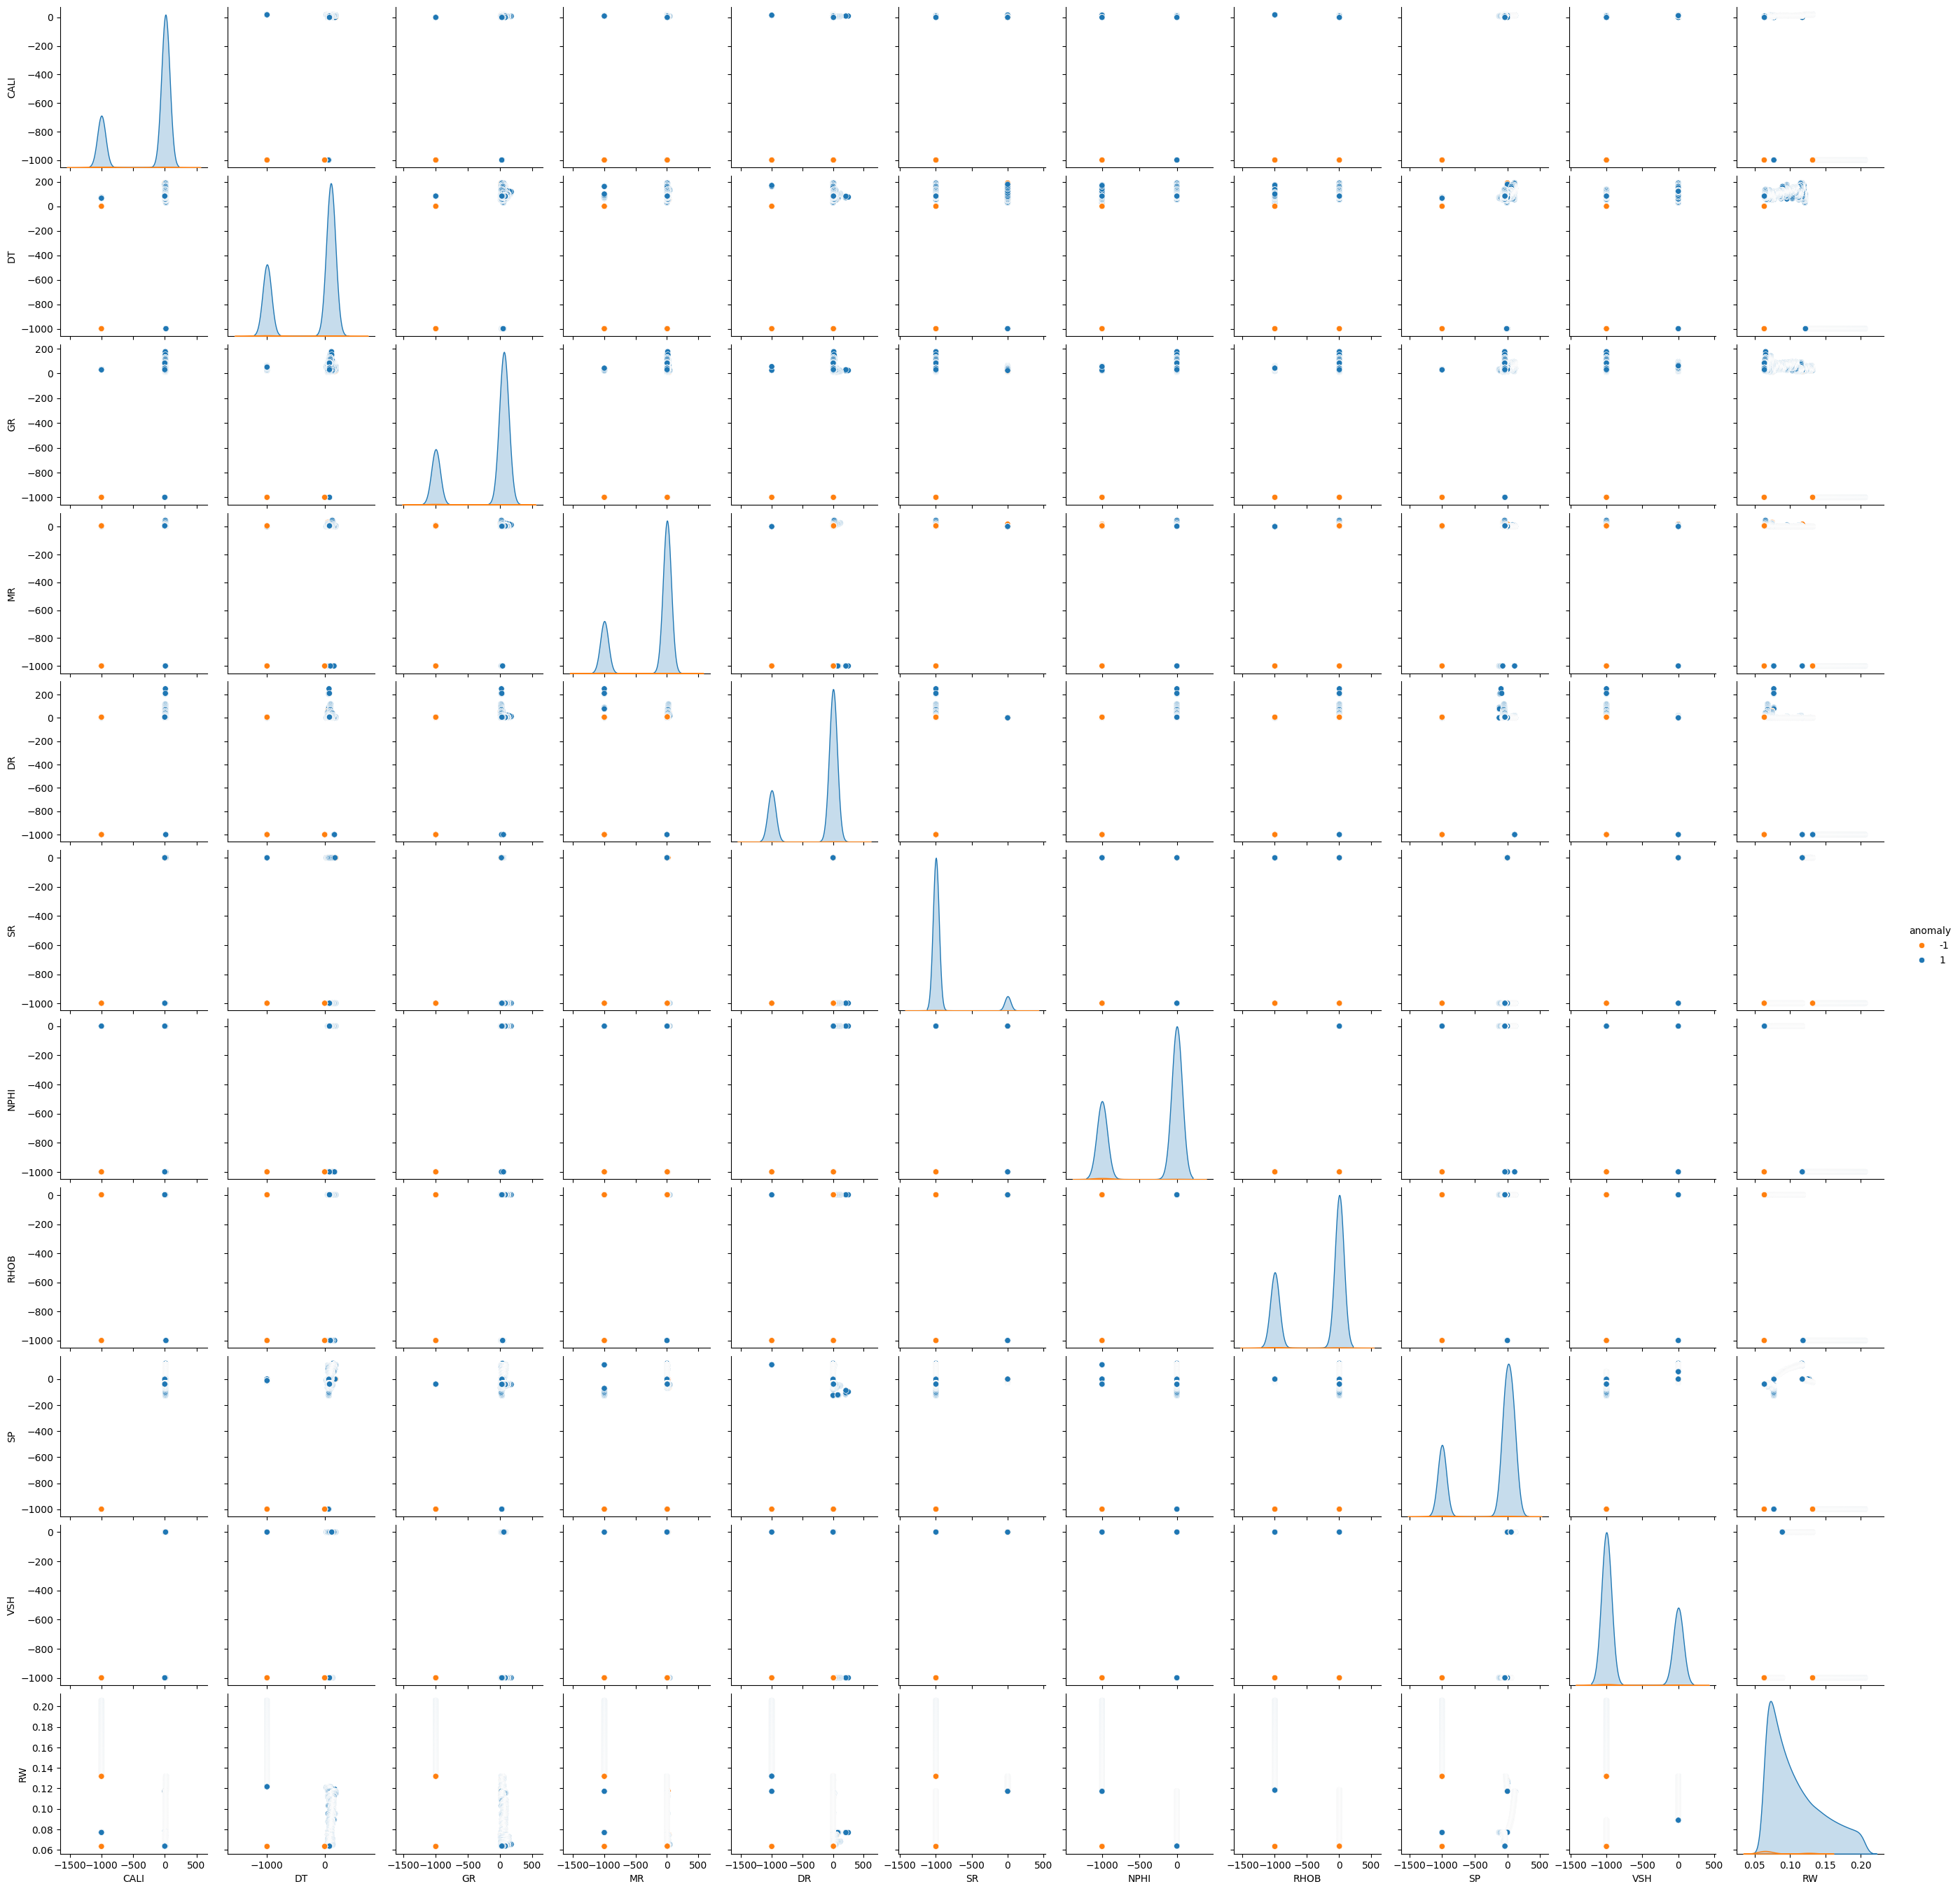

In [22]:
#Outlier plot with orange signifying outliers
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(data, vars=anomaly_inputs, hue='anomaly', palette=palette)

In [23]:
#Replace rows of anomaly inputs with -999.25 for outliers
data.loc[data['anomaly'] == -1, anomaly_inputs] = -999.25

### ***3.2. Interpolation for anomaly in dataframe***

#### **3.2.1. Determining if a row needs interpolation or not** <br>

In [24]:
interpolate = []
for h in data['WELL'].unique():
    data_WELL = data[data['WELL'] == h]
    for i in range(0, len(list(data_WELL.anomaly))):
        if list(data_WELL.anomaly)[i] == -1:
            if (i == (len(list(data_WELL.anomaly))-1)) | (i == 0):
                interpolate.append(-1)
            elif list(data_WELL.anomaly)[i-1] & list(data_WELL.anomaly)[i+1] == 1:
                interpolate.append(1)
            else:
                interpolate.append(0)
        elif list(data_WELL.anomaly)[i] == 1:
            interpolate.append(0)

In [25]:
#Add interpolate column to dataframe with value of 1 defined as "interpolation needed" and -1 defined as "extrapolation needed"
data['interpolate'] = interpolate

#### **3.2.2. Interpolating -999.25 value to obtain clean data** <br>

In [26]:
param = 'DEPT'
for i in anomaly_inputs:
    for j in range(0, len(list(data[i]))-1):
        if (list(data[i])[j] == -999.25) & (interpolate[j] == 1):
            data[i].iloc[j] = data[i].iloc[j-1] + (data[param].iloc[j] - data[param].iloc[j-1])*(data[i].iloc[j+1] - data[i].iloc[j-1])/(data[param].iloc[j+1] - data[param].iloc[j-1])          
        elif interpolate[j] == -1:
            if data['WELL'].nunique() == 1:
                data[i].iloc[j] = data[i].iloc[j+1] + (data[param].iloc[j] - data[param].iloc[j+1])*(data[i].iloc[j+2] - data[i].iloc[j+1])/(data[param].iloc[j+2] - data[param].iloc[j+1])
            else :
                if data['WELL'].iloc[j+1] == data['WELL'].iloc[j]:
                    data[i].iloc[j] = data[i].iloc[j+1] + (data[param].iloc[j] - data[param].iloc[j+1])*(data[i].iloc[j+2] - data[i].iloc[j+1])/(data[param].iloc[j+2] - data[param].iloc[j+1])
                elif data['WELL'].iloc[j-1] == data['WELL'].iloc[j]:
                    data[i].iloc[j] = data[i].iloc[j-2] + (data[param].iloc[j] - data[param].iloc[j-2])*(data[i].iloc[j-1] - data[i].iloc[j-2])/(data[param].iloc[j-1] - data[param].iloc[j-2])

In [27]:
data[data[["CALI", "DT", "GR", "MR", "DR", "SR", "NPHI", "RHOB", "SP", "VSH"]] < 0].count()

DEPT                  0
CALI               3636
DT                 4413
GR                 3632
MR                 3659
DR                 3621
SR                12795
NPHI               4817
RHOB               4715
SP                 8186
VSH                9326
RW                    0
WELL                  0
anomaly_scores        0
anomaly               0
interpolate           0
dtype: int64

In [28]:
#Replace the remaining -999 value that is not interpolated with NaN
data = data.replace(-999.25, np.nan)

In [29]:
data.describe()

DEPT          CALI           DT            GR            MR  \
count  13981.000000  10363.000000  9579.000000  10364.000000  10340.000000   
mean    3495.000000     11.291106   107.219044     63.337667      1.447527   
std     2018.055696     20.398591    30.122347     33.481407     20.189644   
min        0.000000   -499.625000  -473.175000   -493.545000   -499.408700   
25%     1747.500000      9.390000    89.676300     42.160000      0.716100   
50%     3495.000000     12.340000   108.620000     64.860000      0.929000   
75%     5242.500000     12.730000   122.120500     79.442500      2.415500   
max     6990.000000     22.270000   191.061000    176.800000     46.344700   

                 DR           SR         NPHI         RHOB            SP  \
count  10378.000000  1199.000000  9168.000000  9277.000000  10363.000000   
mean       2.193154    -4.189620     0.203016     1.729901     19.014115   
std       21.502830    48.689544    10.439683    16.639972     59.996713   
min     -499.447250  -499.537900  -499.604300  -498.720000   -532.925000   
25%        0.800000     0.584800     0.364275     2.182600    -37.100000   
50%        1.038850     0.685500     0.431550     2.286700     18.300000   
75%        2.774125     0.825050     0.487125     2.420000     74.100000   
max      249.379000     2.992300     0.813700     2.770000    121.100000   

               VSH            RW  anomaly_scores       anomaly   interpolate  
count  4668.000000  13862.000000    13981.000000  13981.000000  13981.000000  
mean     -0.721387     -0.540733        0.169809      0.979973      0.001431  
std      24.797628     17.742844        0.069685      0.199138      0.039644  
min    -499.625000   -499.593197       -0.088954     -1.000000     -1.000000  
25%       0.235350      0.076867        0.131111      1.000000      0.000000  
50%       0.643150      0.097071        0.196581      1.000000      0.000000  
75%       0.869500      0.132129        0.225084      1.000000      0.000000  
max       1.000000      0.205728        0.261823      1.000000      1.000000

In [30]:
data.isnull().sum() * 100 / len(data)

DEPT               0.000000
CALI              25.877977
DT                31.485588
GR                25.870825
MR                26.042486
DR                25.770689
SR                91.424076
NPHI              34.425291
RHOB              33.645662
SP                25.877977
VSH               66.611830
RW                 0.851155
WELL               0.000000
anomaly_scores     0.000000
anomaly            0.000000
interpolate        0.000000
dtype: float64

In [31]:
#Drop anomaly_scores, anomaly, and interpolate from dataframe
data = data.drop(['anomaly_scores', 'anomaly', 'interpolate'], axis=1)

#### **3.2.3. Data Validation** <br>

In [32]:
data[["CALI", "DT", "GR", "MR", "DR", "SR", "NPHI", "RHOB", "SP", "VSH"]].describe()

CALI           DT            GR            MR            DR  \
count  10363.000000  9579.000000  10364.000000  10340.000000  10378.000000   
mean      11.291106   107.219044     63.337667      1.447527      2.193154   
std       20.398591    30.122347     33.481407     20.189644     21.502830   
min     -499.625000  -473.175000   -493.545000   -499.408700   -499.447250   
25%        9.390000    89.676300     42.160000      0.716100      0.800000   
50%       12.340000   108.620000     64.860000      0.929000      1.038850   
75%       12.730000   122.120500     79.442500      2.415500      2.774125   
max       22.270000   191.061000    176.800000     46.344700    249.379000   

                SR         NPHI         RHOB            SP          VSH  
count  1199.000000  9168.000000  9277.000000  10363.000000  4668.000000  
mean     -4.189620     0.203016     1.729901     19.014115    -0.721387  
std      48.689544    10.439683    16.639972     59.996713    24.797628  
min    -499.537900  -499.604300  -498.720000   -532.925000  -499.625000  
25%       0.584800     0.364275     2.182600    -37.100000     0.235350  
50%       0.685500     0.431550     2.286700     18.300000     0.643150  
75%       0.825050     0.487125     2.420000     74.100000     0.869500  
max       2.992300     0.813700     2.770000    121.100000     1.000000

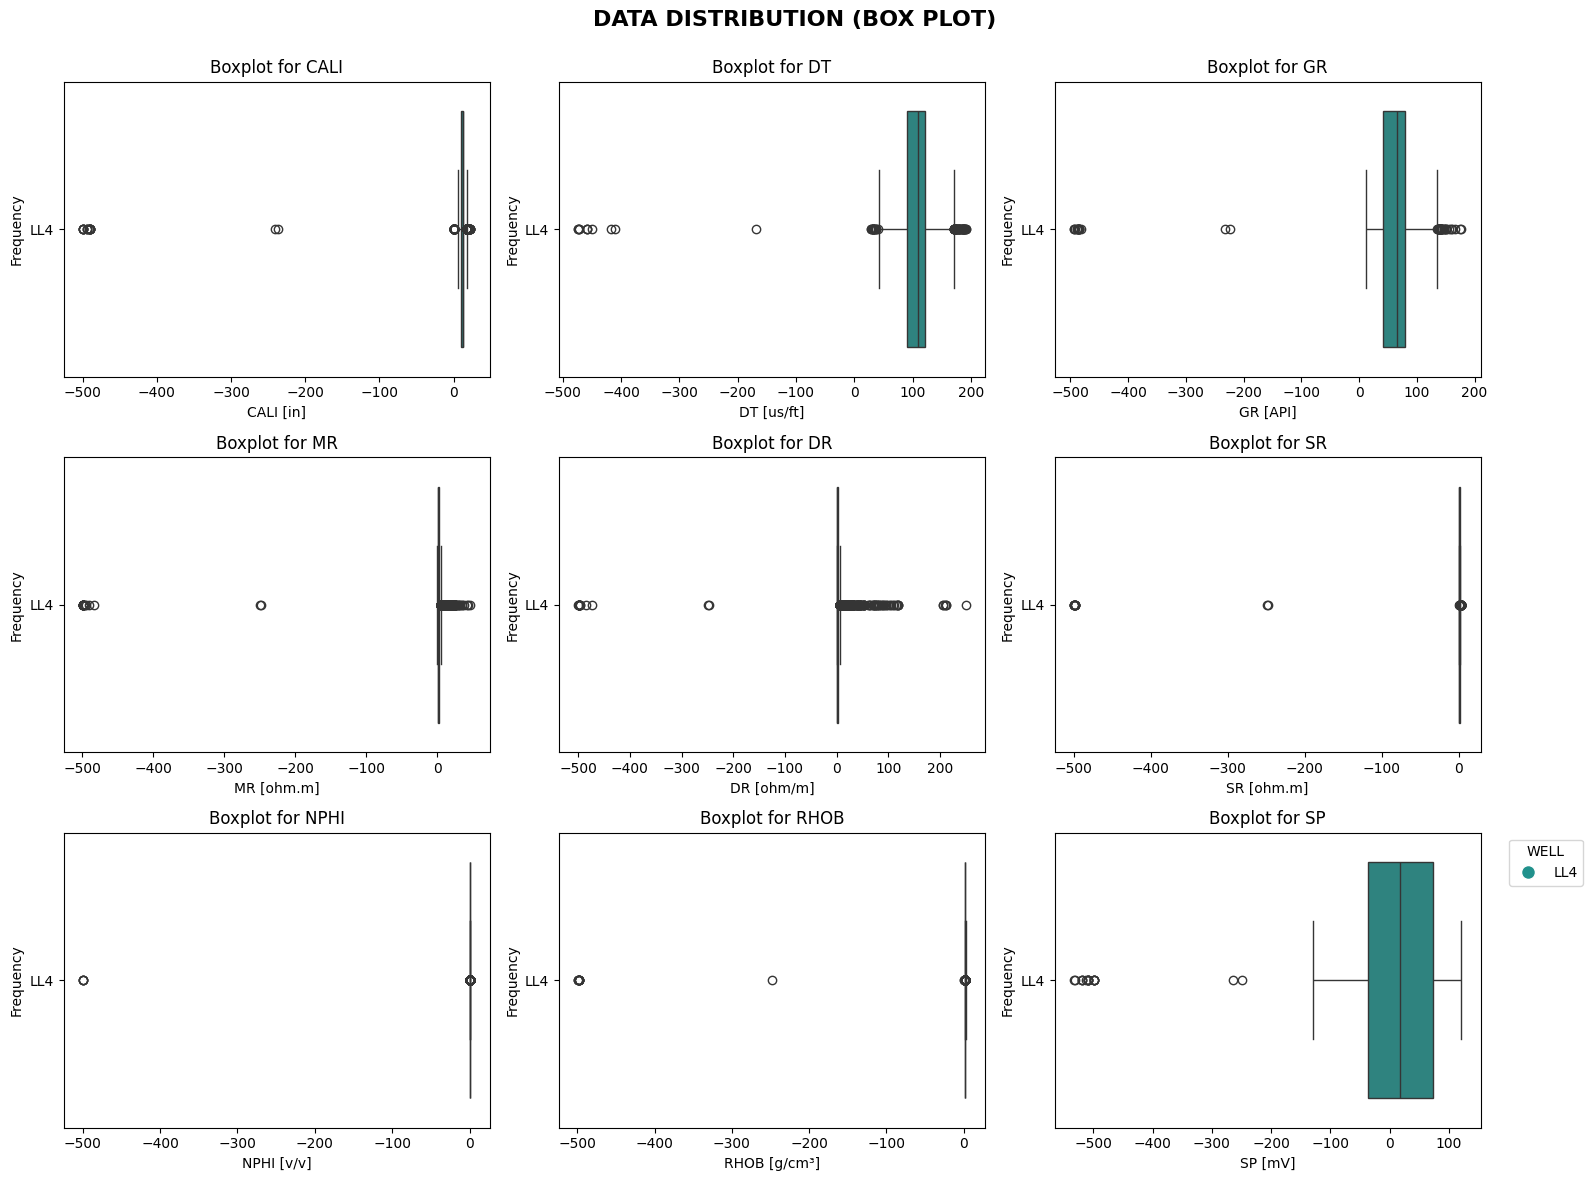

In [33]:
boxplot(data)

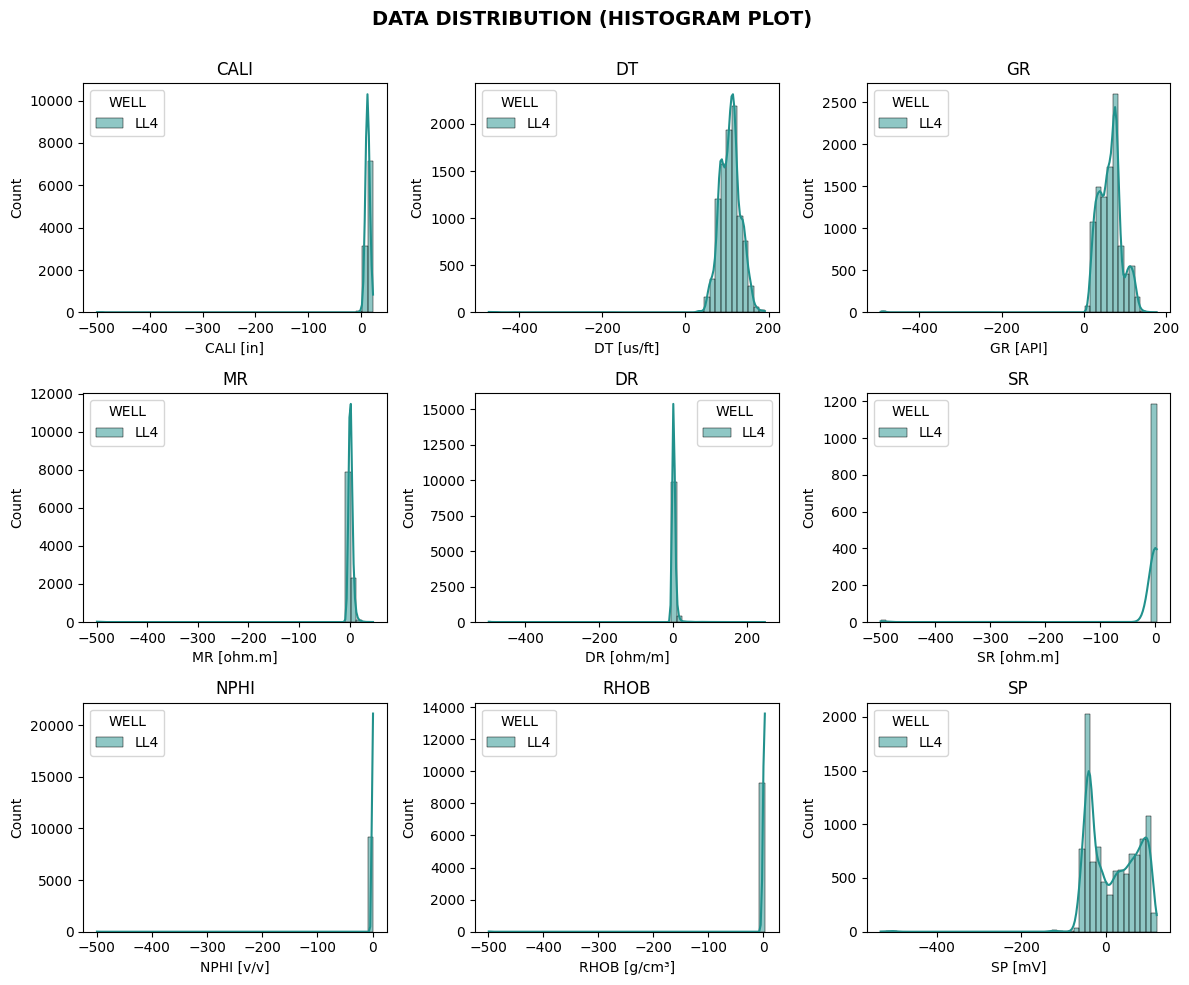

In [34]:
histplot(data)

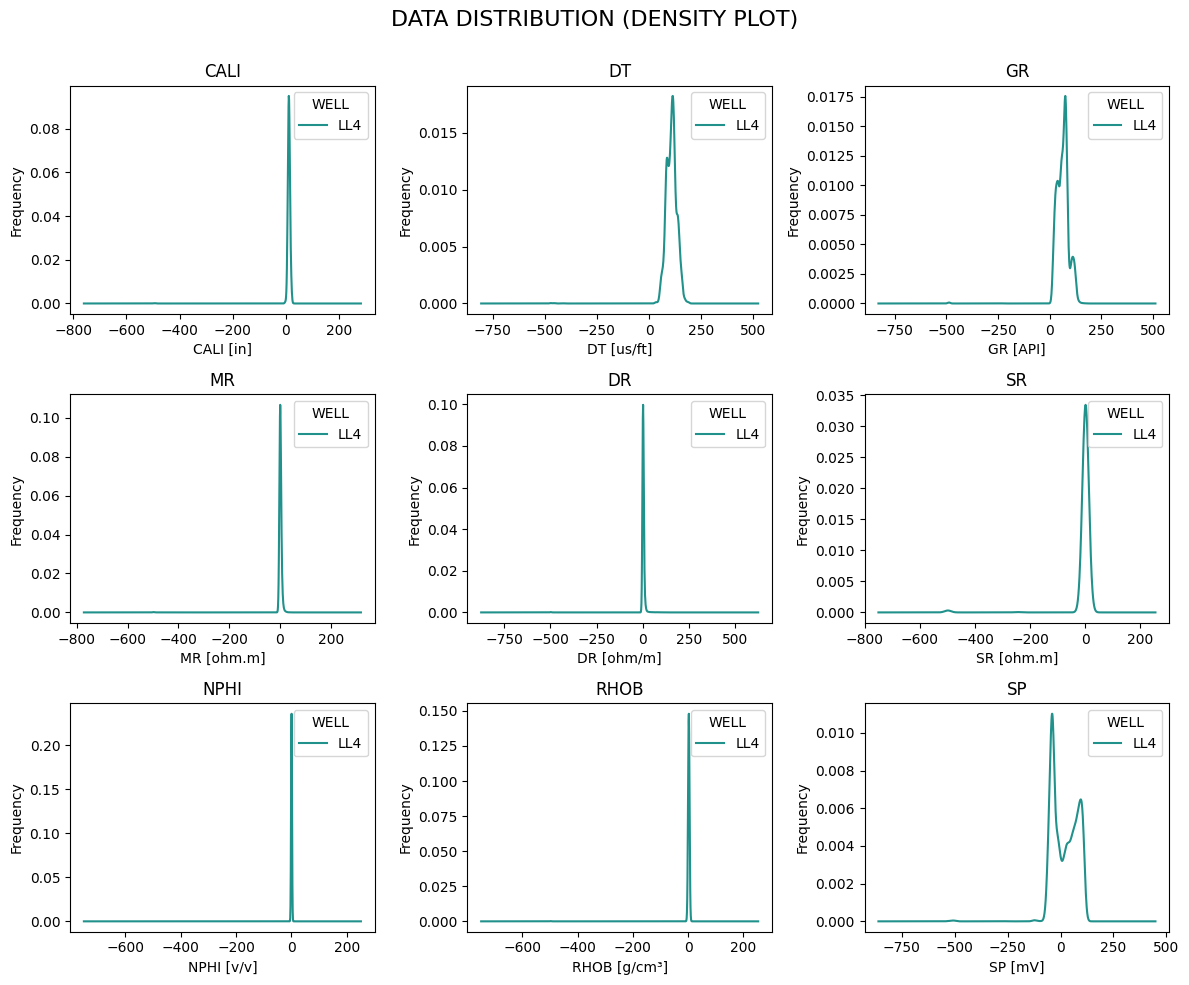

In [35]:
densityplot(data)

#### **3.2.4. Save Clean Data** <br>

In [36]:
#export dataframe to txt
# new_header = "WELL DEPT GR CALI SP DR MR SR RHOB NPHI DT WELL" ["CALI", "DT", "GR", "MR", "DR", "SR", "NPHI", "RHOB", "SP"]
new_header = "DEPT CALI DT GR MR DR SR NPHI RHOB SP VSH RW WELL"
# data_name = "data_clean_LL4_mean.txt"
np.savetxt(data_name, data, fmt='%s', delimiter='\t', header=new_header, comments='')

# **4. Data Selection, Normalization, Well Selection, and Input Core Parameter for Selected Well**

### ***4.1. Clean Data Selection***

In [37]:
data_clean = pd.read_table(data_name, delim_whitespace=True)

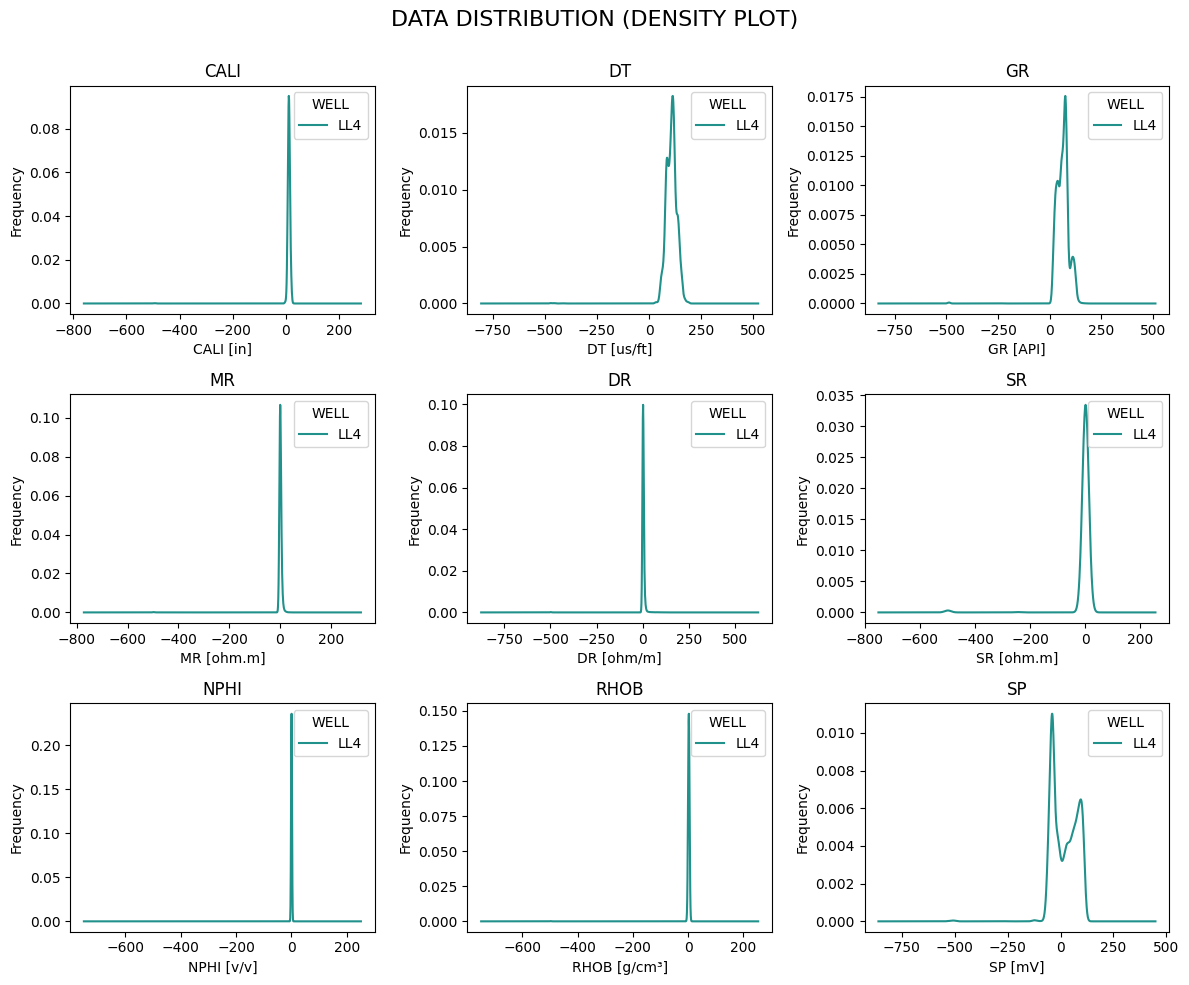

In [38]:
densityplot(data_clean)

### ***4.2. Data Normalization***

In [39]:
def normalise(curve, ref_low, ref_high, well_low, well_high):
    return ref_low + ((ref_high - ref_low) * ((curve - well_low) / (well_high - well_low)))

def normalise_log(df, key_well, log):
    for i in log:
        df['05_PERC'] = df['WELL'].map(df.groupby('WELL')[i].quantile(0.05))
        df['95_PERC'] = df['WELL'].map(df.groupby('WELL')[i].quantile(0.95))
        key_well_low = df.groupby('WELL')[i].quantile(0.05)[key_well]
        key_well_high = df.groupby('WELL')[i].quantile(0.95)[key_well]
        list_norm = df.apply(lambda x: normalise(x[i], key_well_low, key_well_high, x['05_PERC'], x['95_PERC']), axis=1)
        df = df.drop([i, '05_PERC', '95_PERC'], axis=1)
        df[i] = list_norm

    return df

In [40]:
data_clean_backup = data_clean.copy()

In [41]:
log = ["CALI", "DT", "GR", "MR", "DR", "SR", "NPHI", "RHOB", "SP", "VSH"]
key_well = 'LL4'

data__clean_normalized = normalise_log(data_clean, key_well, log)

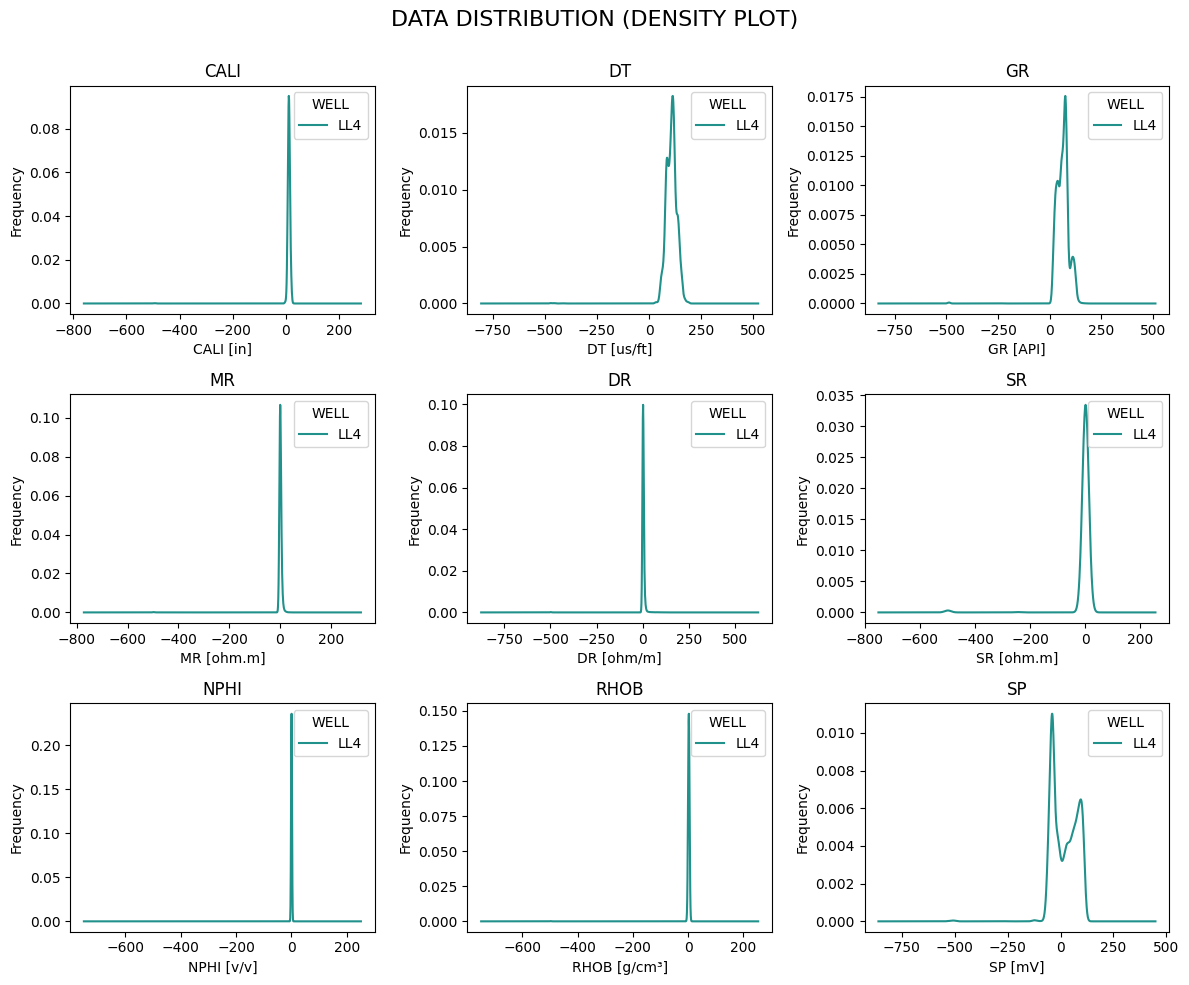

In [42]:
densityplot(data__clean_normalized)

### ***4.3. Select the Well***

In [43]:
# Create a copy of the data for selected well (Whicher-2)
selected_data = data__clean_normalized[data__clean_normalized['WELL'] == "LL4"].copy()

### ***4.4. Input Core Data (Porosity and Permeability) for Selected Well***

In [44]:
selected_data["core_por"] = ""
selected_data["core_perm"] = ""

# Define the number of random samples you want
num_samples = 100  # You can change this to the desired number of samples

# Generate random values for 'DEPT' between 900 and 4300
dept_values = np.random.uniform(3700, 4000, num_samples)

# Generate random values for 'core_por' between 0 and 1 and "core_perm" between 0 and 1000
core_por_values = np.random.uniform(0, 1, num_samples)
core_perm_values = np.random.uniform(0, 1000, num_samples)

# Create a dictionary with the generated values. This for example only
dict_core = {
    'DEPT': dept_values.tolist(),  # Convert to a list
    'core_por': core_por_values.tolist(),  # Convert to a list
    "core_perm" : core_perm_values.tolist() # Convert to a list
}

# must inpute manually based on core data
"""dict_core = {'DEPT':[4220,4240,4260],
        'DEPT':[4220,4240,4260],
        'core_por':[0.148, 0.287,0.103],
        'core_perm':[0.0001,0.0001,0.0001]
       } """


core_selected_data = pd.DataFrame(dict_core)
selected_data.set_index("DEPT");

## **5. DISPLAY DATA LOGS**
Display is done by describing a function named combo_plot<br>
combo_plot displays three traject, namely:<br>
- Traject 1: GR, SP, CALI
- Traject 2: Resistivities (ILD, ILM, ILS, LL8, SFL, or other)
- Traject 3: Density (RHOB), Sonic(DT) and Neutronic (NPHI)

In [45]:
# Create the figure and subplots
def combo_plot(data, top_depth, bottom_depth, figure_height,subplotadjust,SP_min,SP_max,CALI_min,CALI_max,GR_min,GR_max,DR_min,DR_max,MR_min,MR_max,SR_min,SR_max,RHOB_min,RHOB_max,NPHI_min,NPHI_max,DT_min,DT_max,smoothing_traject1,smoothing_traject2,smoothing_traject3,major_ticks_interval,minor_ticks_interval):
    
    logs=data[(data.DEPT >= top_depth) & (data.DEPT <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,figure_height), sharey=True) #pembuatan format 1 baris 3 kolom, width 12 height 10, dan sumbu y yang sama (sharey)
    fig.suptitle(f"LOG CURVE".upper(), fontsize=22)
    fig.subplots_adjust(top=subplotadjust,wspace=0.1)


    #General setting for all axis
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.yaxis.grid(True, which='minor', linestyle=':')
        axes.yaxis.grid(True, which='major', linestyle='-', linewidth='1')
        axes.yaxis.set_major_locator(ticker.MultipleLocator(major_ticks_interval))
        axes.yaxis.set_minor_locator(ticker.MultipleLocator(minor_ticks_interval))
        axes.get_xaxis().set_visible(False) 
        
    #Smoothing the graph
    if (smoothing_traject1 == "yes"):
        logs.GR.dropna(inplace=True)
        logs.CALI.dropna(inplace=True)
        logs.SP.dropna(inplace=True)
        
        logs.GR = logs[["GR"]].apply(savgol_filter,  window_length=5, polyorder=3)
        logs.CALI = logs[["CALI"]].apply(savgol_filter,  window_length=5, polyorder=3)
        logs.SP = logs[["SP"]].apply(savgol_filter,  window_length=5, polyorder=3)

    if (smoothing_traject2 == "yes"):
        logs.DR.dropna(inplace=True)
        logs.MR.dropna(inplace=True)
        logs.SR.dropna(inplace=True)
        
        logs.DR = logs[["DR"]].apply(savgol_filter,  window_length=5, polyorder=3)
        logs.MR = logs[["MR"]].apply(savgol_filter,  window_length=5, polyorder=3)
        logs.SR = logs[["SR"]].apply(savgol_filter,  window_length=5, polyorder=3)    
        
    if (smoothing_traject3 == "yes"):
        logs.RHOB.dropna(inplace=True)
        logs.NPHI.dropna(inplace=True)
        logs.DT.dropna(inplace=True)
        
        logs.RHOB = logs[["RHOB"]].apply(savgol_filter,  window_length=5, polyorder=3)
        logs.NPHI = logs[["NPHI"]].apply(savgol_filter,  window_length=5, polyorder=3)
        logs.DT = logs[["DT"]].apply(savgol_filter,  window_length=5, polyorder=3)
        
#First Trajectory: GR, CALI, SP
    #Gamma Ray lot    
    if ("GR" in data.columns and (GR_min!=0 or GR_max!=0)):
        ax01=ax[0].twiny()
        if GR_min != "auto" and GR_max != "auto":
            ax01.set_xlim(GR_min,GR_max)
        ax01.yaxis.grid(True, which='major', linestyle='-', linewidth='1')
        ax01.yaxis.set_major_locator(ticker.MultipleLocator(50))
        ax01.plot(logs.GR, logs.DEPT, label='GR[api]', color='green') 
        ax01.spines['top'].set_position(('outward',80))
        ax01.set_xlabel('GR[api]',color='green')    
        ax01.tick_params(axis='x', colors='green')

    #Caliper Plot
    if ("CALI" in data.columns and (CALI_min!=0 or CALI_max!=0)):
        ax02=ax[0].twiny()
        if CALI_min != "auto" and CALI_max != "auto":
            ax02.set_xlim(CALI_min,CALI_max)
        ax02.plot(logs.CALI, logs.DEPT, '--', label='CALN[in]', color='black')
        ax02.spines['top'].set_position(('outward',40))
        ax02.set_xlabel('CALI[in]',color='black')    
        ax02.tick_params(axis='x', colors='black') 
        #ax02.axvline(x=7.9, linewidth=2, color='black') #digunakan untuk plot bit size ukuran 7.9 in
    
    #Spontaneous Potential Plot
    if ("SP" in data.columns and (SP_min!=0 or SP_max!=0)):
        ax03=ax[0].twiny()
        if SP_min != "auto" and SP_max != "auto":
            ax03.set_xlim(SP_min,SP_max)
        ax03.spines['top'].set_position(('outward',0))
        ax03.set_xlabel("SP [mV]")
        ax03.plot(logs.SP, logs.DEPT, label='SP[mV]', color='blue')
        ax03.set_xlabel('SP[mV]',color='blue')
        ax03.tick_params(axis='x', colors='blue')
        ax03.grid(True)


#Second Trajectory: DR, MR, SR
    #Deep Resistivity Plot
    if ("DR" in data.columns and (DR_min!=0 or DR_max!=0)):
        ax11=ax[1].twiny()
        if DR_min != "auto" and DR_max != "auto":
            ax11.set_xlim(DR_min,DR_max)
        ax11.set_xscale('log')
        ax11.grid(visible=None, which='both')
        ax11.spines['top'].set_position(('outward',80))
        ax11.set_xlabel('Deep Resistivity [ohm.m]', color='red')
        ax11.plot(logs.DR, logs.DEPT, label='DR [ohm.m]', color='red')
        ax11.tick_params(axis='x', colors='red')    
    
    #Medium Resistivity Plot
    if("MR" in data.columns and (MR_min!=0 or MR_max!=0)):
        ax12=ax[1].twiny()
        if MR_min != "auto" and MR_max != "auto":
            ax12.set_xlim(MR_min,MR_max)
        ax12.set_xscale('log')
        ax12.grid(visible=None, which='both')
        ax12.spines['top'].set_position(('outward',40))
        ax12.set_xlabel('Medium Resistivity [ohm.m]', color='purple')    
        ax12.plot(logs.MR, logs.DEPT, label='MR [ohm.m]', color='purple')
        ax12.tick_params(axis='x', colors='purple')
    
    #Shallow Resistivity Plot
    if("SR" in data.columns and (SR_min!=0 or SR_max!=0)):
        ax13=ax[1].twiny()
        if SR_min != "auto" and SR_max != "auto":
            ax13.set_xlim(SR_min,SR_max)
        ax13.set_xscale('log')
        ax13.grid(visible=None, which='both')
        ax13.spines['top'].set_position(('outward',0))
        ax13.set_xlabel('Shallow Resistivity [ohm.m]',color='black')
        ax13.plot(logs.SR, logs.DEPT, '--',label='SR[ohm.m]', color='black')
        ax13.tick_params(axis='x', colors='black')


#Third Trajectory: RHOB, NPHI, DT
    #Density Plot
    if ("RHOB" in data.columns and (RHOB_min!=0 or RHOB_max!=0)):
        ax21=ax[2].twiny()
        if RHOB_min != "auto" and RHOB_max != "auto":
            ax21.set_xlim(RHOB_min,RHOB_max)
        ax21.plot(logs.RHOB, logs.DEPT ,label='RHOB[g/cc]', color='red') 
        ax21.spines['top'].set_position(('outward',80))
        ax21.set_xlabel('RHOB[g/cc]',color='red')
        ax21.tick_params(axis='x', colors='red')

    #Neutron Porosity Plot
    if ("NPHI" in data.columns and (NPHI_min!=0 or NPHI_max!=0)):
        ax22=ax[2].twiny()
        if NPHI_min != "auto" and NPHI_max != "auto":
            ax22.set_xlim(NPHI_min,NPHI_max)
        ax22.invert_xaxis()
        ax22.plot(logs.NPHI, logs.DEPT, label='NPHI[%]', color='green') 
        ax22.spines['top'].set_position(('outward',40))
        ax22.set_xlabel('NPHI[%]', color='green')    
        ax22.tick_params(axis='x', colors='green')

    #Sonic Plot 
    if ("DT" in data.columns and (DT_min!=0 or DT_max!=0)):
        ax23=ax[2].twiny()
        ax23.grid(True, which='both')
        if DT_min != "auto" and DT_max != "auto":
            ax23.set_xlim(DT_min,DT_max)
        ax23.spines['top'].set_position(('outward',0))
        ax23.set_xlabel('DT[us/ft]')
        ax23.plot(logs.DT, logs.DEPT, label='DT[us/ft]', color='blue')
        ax23.set_xlabel('DT[us/ft]', color='blue')    
        ax23.tick_params(axis='x', colors='blue')

In [46]:
def custom_interpretation_plot(logs, depth_start, depth_end, *custom_logs, units):
    num_tracks = len(custom_logs)
    fig, ax = plt.subplots(nrows=1, ncols=num_tracks, figsize=(15, 20), sharey=True)
    fig.suptitle("Custom Interpretation Plot", fontsize=22)

    # Calculate top value with less free space based on the number of tracks
    #top_value = 1 - 0.015 * num_tracks

    # Adjust top parameter to leave less free space at the top
    #fig.subplots_adjust(top=top_value, wspace=0.2)

    units = units  # in list

    # General setting for all axes
    for axes in ax:
        axes.set_ylim(depth_start, depth_end)
        axes.invert_yaxis()
        axes.yaxis.grid(True, which='minor', linestyle=':')
        axes.yaxis.grid(True, which='major', linestyle='-', linewidth='1')
        axes.yaxis.set_major_locator(ticker.MultipleLocator(10))
        axes.yaxis.set_minor_locator(ticker.MultipleLocator(1))
        axes.get_xaxis().set_visible(False)

    # Customizing each track with unit and color
    for i, log_name in enumerate(custom_logs):
        current_ax = ax[i].twiny()
        current_ax.plot(logs[log_name], logs.DEPT, label=f'{log_name} [{units[i]}]', color='C'+str(i))
        if log_name == "DR" or log_name == "MR" or log_name == "SR":
            current_ax.set_xscale('log')
        current_ax.set_xlabel(f'{log_name} [{units[i]}]', color='C'+str(i))
        current_ax.tick_params(axis='x', colors='C'+str(i))
        current_ax.spines['top'].set_position(('outward',0))
        current_ax.legend(loc='lower right', facecolor='white', framealpha=1, fontsize=7)
    plt.show()


In [47]:
selected_data.describe()

DEPT            RW          CALI           DT            GR  \
count  13981.000000  13862.000000  10363.000000  9579.000000  10364.000000   
mean    3495.000000     -0.540733     11.291106   107.219044     63.337667   
std     2018.055696     17.742844     20.398591    30.122347     33.481407   
min        0.000000   -499.593197   -499.625000  -473.175000   -493.545000   
25%     1747.500000      0.076867      9.390000    89.676300     42.160000   
50%     3495.000000      0.097071     12.340000   108.620000     64.860000   
75%     5242.500000      0.132129     12.730000   122.120500     79.442500   
max     6990.000000      0.205728     22.270000   191.061000    176.800000   

                 MR            DR           SR         NPHI         RHOB  \
count  10340.000000  10378.000000  1199.000000  9168.000000  9277.000000   
mean       1.447527      2.193154    -4.189620     0.203016     1.729901   
std       20.189644     21.502830    48.689544    10.439683    16.639972   
min     -499.408700   -499.447250  -499.537900  -499.604300  -498.720000   
25%        0.716100      0.800000     0.584800     0.364275     2.182600   
50%        0.929000      1.038850     0.685500     0.431550     2.286700   
75%        2.415500      2.774125     0.825050     0.487125     2.420000   
max       46.344700    249.379000     2.992300     0.813700     2.770000   

                 SP          VSH  
count  10363.000000  4668.000000  
mean      19.014115    -0.721387  
std       59.996713    24.797628  
min     -532.925000  -499.625000  
25%      -37.100000     0.235350  
50%       18.300000     0.643150  
75%       74.100000     0.869500  
max      121.100000     1.000000

### **5.1. Full depth display**

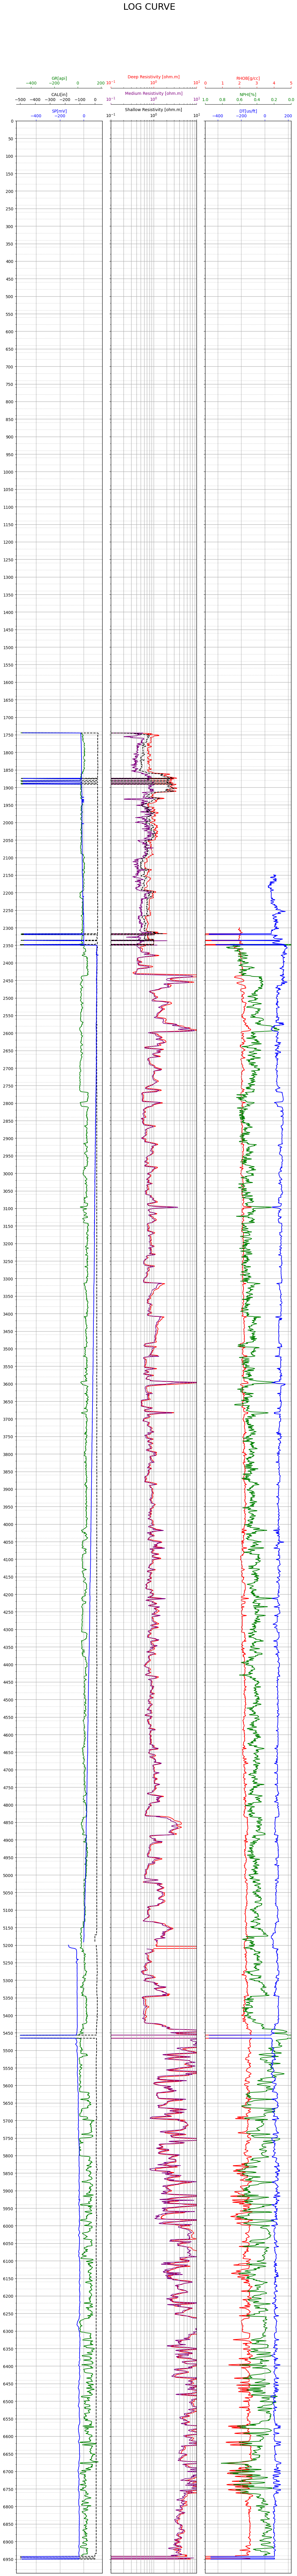

In [48]:
# DISPLAYS LOG DATA FROM THE END TO THE BOTTOM (MENTAHAN)
SP_min = "auto" #lowersp limit sp
SP_max = "auto" #sp upper limit
CALI_min = "auto" #CALI lower limit
CALI_max = "auto" #CALI upper limit
GR_min = "auto" #lower limit GR
GR_max = "auto" #upper limit of GR
DR_min = 0.1 #DR lower limit
DR_max = 10 #DR upper limit
MR_min = 0.1 #MR lower bound
MR_max = 10 #MR upper limit
SR_min = 0.1 #lower SR limit
SR_max = 10 #SR upper limit
RHOB_min = 0 #lower limit of RHOB
RHOB_max = 5 #upper limit of RHOB
NPHI_min = 0 #NPHI lower limit
NPHI_max = 1 #NPHI upper limit
DT_min = "auto" #lowerlimit DT
DT_max = "auto" #upper limit of DT
smoothing_traject1 = "no" #default "no"
smoothing_traject2 = "no" #default "no"
smoothing_traject3 = "no" #default "no"

combo_plot(
    selected_data,
    selected_data.DEPT.min(),
    selected_data.DEPT.max(),
    100,               #figure height in inch
    0.94,              #figure position 
    SP_min,
    SP_max,
    CALI_min,
    CALI_max,
    GR_min,
    GR_max,
    DR_min,
    DR_max,
    MR_min,
    MR_max,
    SR_min,
    SR_max,
    RHOB_min,           
    RHOB_max,                  
    NPHI_min,                  
    NPHI_max,
    DT_min,
    DT_max,
    smoothing_traject1,
    smoothing_traject2,
    smoothing_traject3,
    100,
    20
    )

### **5.2. Selected Depth Display**

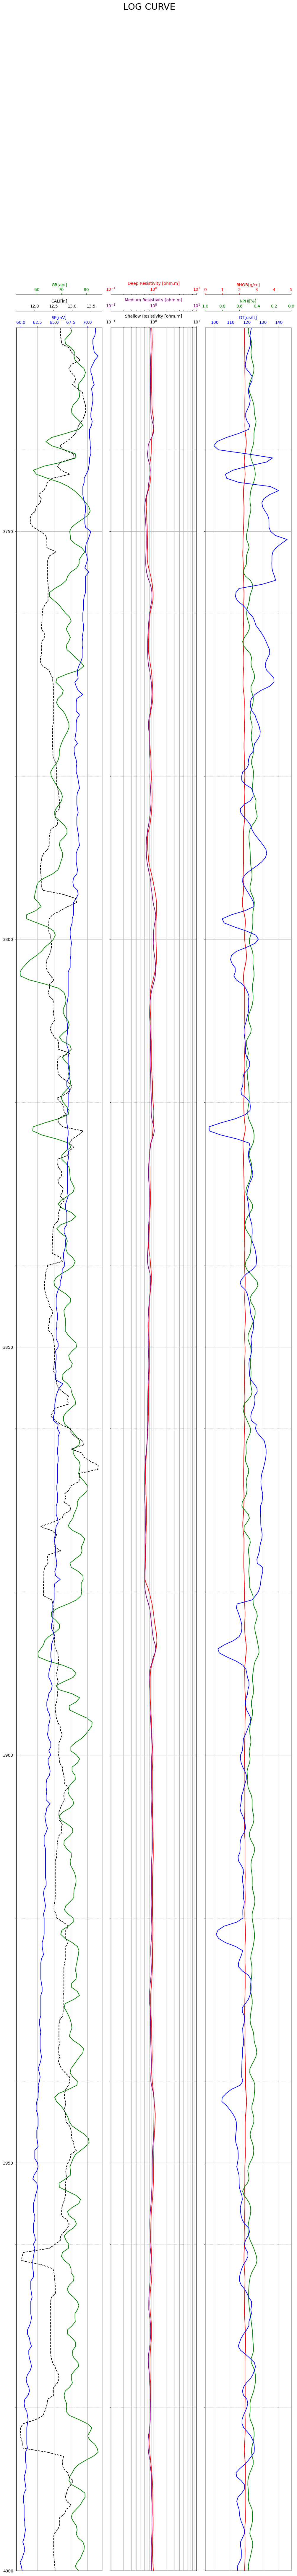

In [49]:
#MENAMPILKAN DATA LOG DARI UJUNG ATAS SAMPAI BAWAH YANG DIINGINKAN

depth_start = 3825 - 100
depth_end = 4000

combo_plot(
    selected_data,
    depth_start,
    depth_end,
    100,               #figure height in inch
    0.87,             #figure position 
    SP_min,
    SP_max,
    CALI_min,
    CALI_max,
    GR_min,
    GR_max,
    DR_min,
    DR_max,
    MR_min,
    MR_max,
    SR_min,
    SR_max,
    RHOB_min,           
    RHOB_max,                  
    NPHI_min,                  
    NPHI_max,
    DT_min,
    DT_max,
    smoothing_traject1,
    smoothing_traject2,
    smoothing_traject3,
    100,
    20
    )

### **5.3. Custom Variable Display**

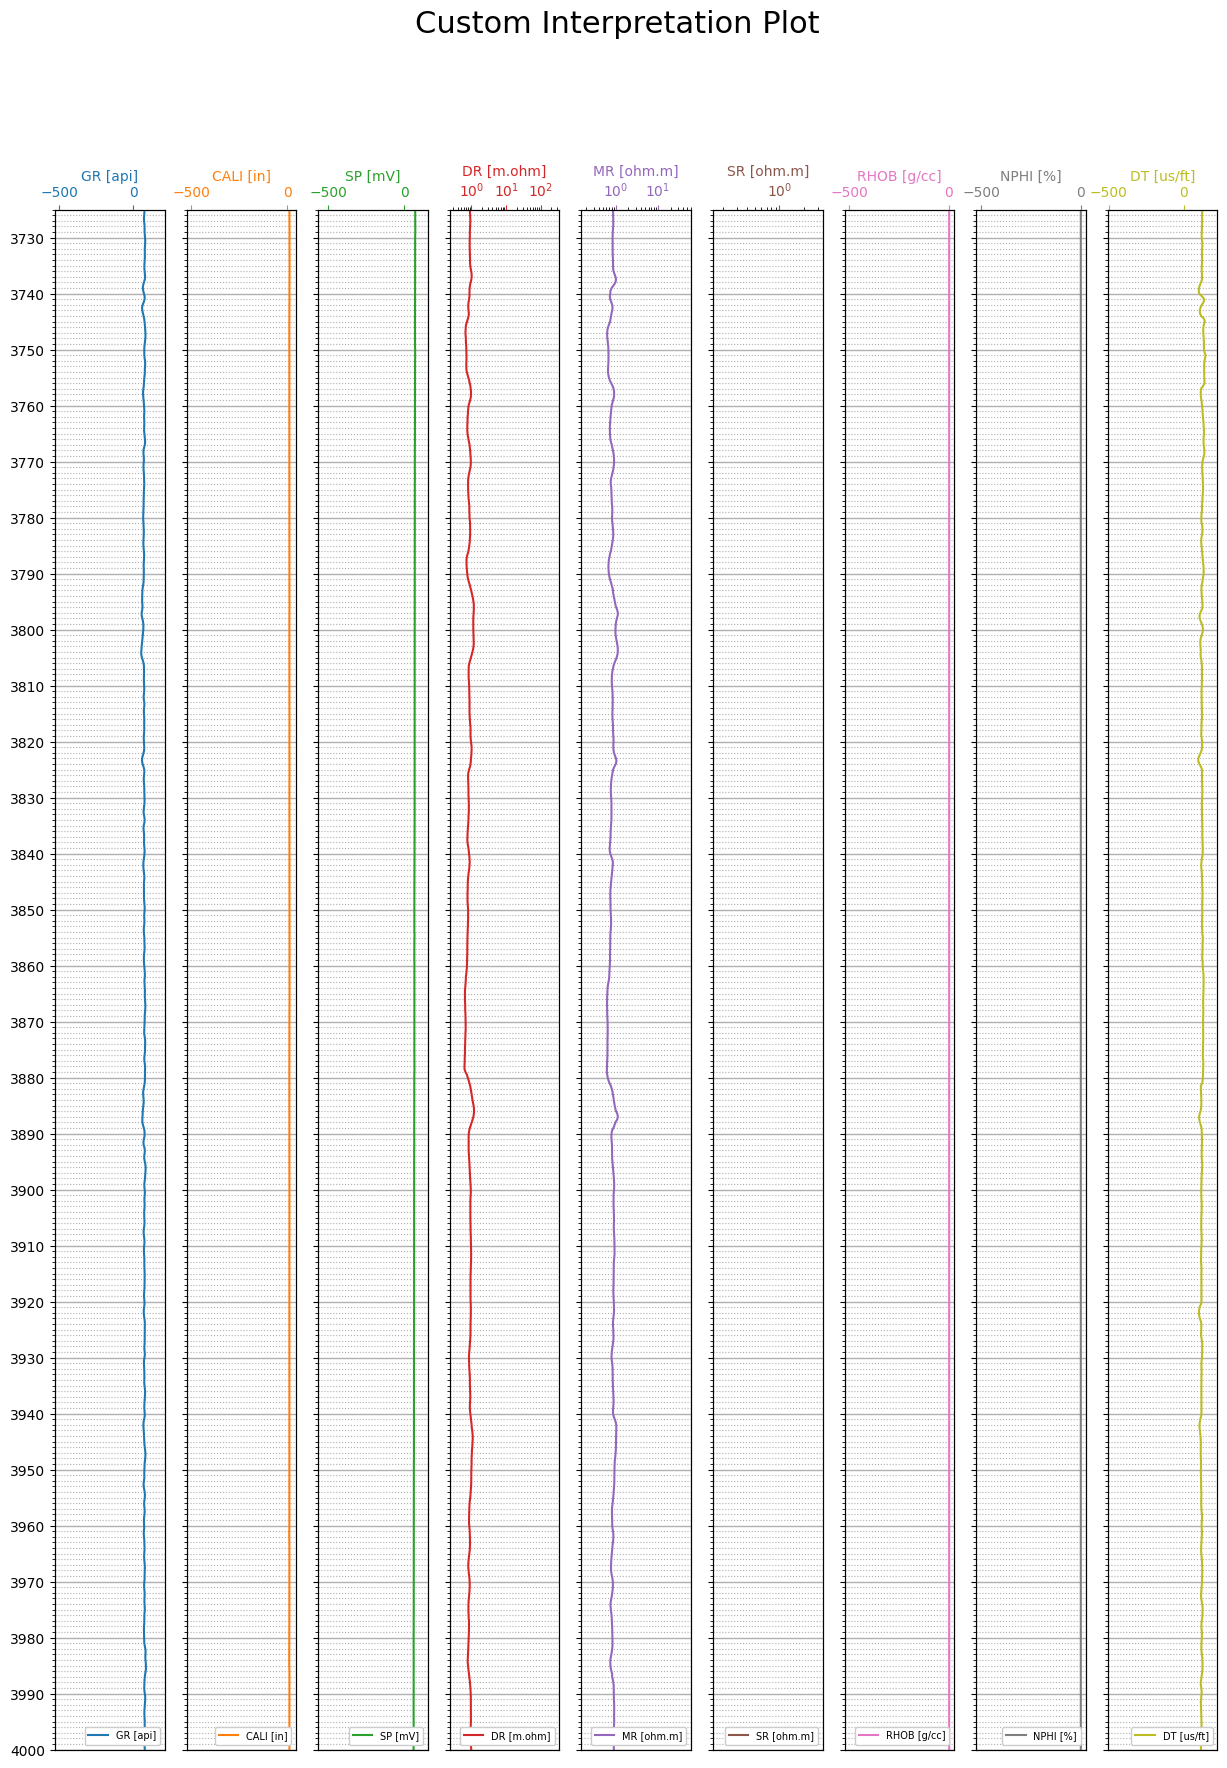

In [50]:
# Ori Unit ["api", "in", "mV", "m.ohm", "ohm.m", "ohm.m", "g/cc", "%", "us/ft"]
# custom_interpretation_plot(selected_data, depth_start, depth_end, "GR", "CALI", "SP", "DR", "MR", "SR", "NPHI", "RHOB", "DT", units=["API", "in", "mV", "ohm/m", "ohm.m", "ohm.m", "v/v", "g/cm³", "us/ft"])

custom_interpretation_plot(selected_data, depth_start, depth_end, "GR", "CALI", "SP", "DR", "MR", "SR", "RHOB", "NPHI", "DT", units=["api", "in", "mV", "m.ohm", "ohm.m", "ohm.m", "g/cc", "%", "us/ft"])

## **6. CLAY VOLUME CALCULATION**
### **6.1. Single Method with Gamma Ray Log**

#### **The calculation of the volume of clay is carried out using five equation options, namely:**

**Linear Gamma Ray Equation:**
- *Formula:* $ VCL_{gr}=I_{gr} = \frac{gr_{log}-gr_{clean}}{gr_{clay}-gr_{clean}}$
- *Explanation:* Calculates the Volume of Clay $VCL_{gr}$ based on gamma ray log $gr_{log}$, clean sand gamma ray $gr_{clean}$, and clay gamma ray $gr_{clay}$.

**Larionov (Tertiary/Young Rocks) Equation:**
- *Formula:* $ VCL_{gr} = 0.083(2^{3.7*I_{gr}}-1)$ 
- *Explanation:* Specifically designed for tertiary/young rocks, using the gamma ray index $I_{gr}$.

**Larionov (Old Rocks) Equation:**
- *Formula:* $ VCL_{gr} = 0.33(2^{2\times I_{gr}}-1)$
- *Explanation* Tailored for old rocks, also utilizing the gamma ray index $I_{gr}$

**Clavier Equation:**
- *Formula:* $ VCL_{gr} = 1.7 - (3.38-(I_{gr}+0.7)^2)^{\frac{1}{2}} $
- *Explanation:* Involves a square root term and is based on the gamma ray index $I_{gr}$.

**Steiber Equation:**
- *Formula:* $ VCL_{gr} = 0.5(\frac{I_{gr}}{1.5-I_{gr}})$
- *Explanation:* Includes a ratio of the gamma ray index $I_{gr}$.

In [51]:
def vclgr(gr_log, gr_clean, gr_clay, correction=None):

    igr=(gr_log-gr_clean)/(gr_clay-gr_clean)      
    vclgr_larionov_young=0.083*(2**(3.7*igr)-1)   
    vclgr_larionov_old=0.33*(2**(2*igr)-1)        
    vclgr_clavier=1.7-(3.38-(igr+0.7)**2)**0.5    
    vclgr_steiber=0.5*igr/(1.5-igr)               

    if correction == "young":
        vclgr=vclgr_larionov_young
    elif correction == "older":
        vclgr=vclgr_larionov_old
    elif correction=="clavier":
        vclgr=vclgr_clavier
    elif correction=="steiber":
        vclgr=vclgr_steiber
    else:
        vclgr=igr
    return vclgr

### **6.2. Single Method with Spontaneous Potential Log:**

The volume of clay $VCL_{sp}$ can be determined using the Spontaneous Potential (SP) log with the following equation:

$$VCL_{sp} = \frac{sp_{log} - sp_{clean}}{sp_{clay} - sp_{clean}}$$

- **Formula Explanation:**
  - $VCL_{sp}$: Volume of Clay using Spontaneous Potential.
  - $sp_{log}$: Spontaneous Potential log value.
  - $sp_{clean}$: SP value in clean formations.
  - $sp_{clay}$: SP value in clay-rich formations.

This equation provides a method for estimating the volume of clay based on the SP log measurements, where the SP log is compared to clean and clay values.


In [52]:
def vclsp(sp_log, sp_clean, sp_clay):
    vclsp=(sp_log-sp_clean)/(sp_clay-sp_clean)
    return vclsp

### **6.3. Single Method with Resistivity Log:**

The volume of clay $V_{rt}$ can be calculated using the Resistivity (RT) log with the following equation:

$$V_{rt} = \frac{rt_{clay}}{rt_{log}} \times \frac{rt_{clean} - rt_{log}}{rt_{clean} - rt_{clay}}$$

- **Formula Explanation:**
  - $V_{rt}$: Volume of Clay using Resistivity log.
  - $rt_{clay}$: Resistivity in clay-rich formations.
  - $rt_{log}$: Resistivity log value.
  - $rt_{clean}$: Resistivity in clean formations.
  - $st_{clay}$: Saturation in clay-rich formations.

If $rt_{log} > 2 \times rt_{clay}$, then the volume of clay $VCL_{rt}$ is calculated as follows:

$$VCL_{rt} = 0.5(2 \times V_{rt})^{(0.67(V_{rt} + 1))}$$

- **Condition Explanation:**
  - $rt_{log}$ greater than twice $rt_{clay}$ triggers the second part of the calculation.

This method provides a way to estimate the volume of clay based on the Resistivity log, with a condition for specific scenarios where $rt_{log}$ exceeds a threshold relative to $rt_{clay}$.


In [53]:
def vclrt(rt_log, rt_clean, rt_clay):
    vrt=(rt_clay/rt_log)*(rt_clean-rt_log)/(rt_clean-rt_clay)
    if (rt_log > 2* rt_clay):
        vclrt = 0.5 * (2 * vrt)** (0.67*(vrt+1))
    else:
        vclrt = vrt
    return vclrt

### **6.4. Dual Method with N-D Crossplot**
Dual methods involve the utilization of neutron-density crossplots, which are based on the correlation between neutron and density measurements. These crossplots depict the identification of a 'clean line' and a 'clay point,' as illustrated in the accompanying graphs.
1. Clean Line: The clean line on the neutron-density crossplot typically represents a linear trend that corresponds to rocks with minimal clay content. Rocks along this line have a consistent ratio of neutron and density measurements. This could correspond to sandstones or other clean, mineral-rich formations.

2. Clay Point: The clay point is a marker on the crossplot that corresponds to clay-rich formations. These formations will exhibit different neutron and density measurements compared to the clean line due to their higher clay content.

The terms **term1** and **term2** are defined as follows:

$$
\text{term1} = (\rho_{\text{clean2}} - \rho_{\text{clean1}}) \cdot (\text{neut}_{\text{log}} - \text{neut}_{\text{clean1}}) - (\rho_{\text{log}} - \rho_{\text{clean1}}) \cdot (\text{neut}_{\text{clean2}} - \text{neut}_{\text{clean1}})
$$

$$
\text{term2} = (\rho_{\text{clean2}} - \rho_{\text{clean1}}) \cdot (\text{neut}_{\text{clay}} - \text{neut}_{\text{clean1}}) - (\rho_{\text{clay}} - \rho_{\text{clean1}}) \cdot (\text{neut}_{\text{clean2}} - \text{neut}_{\text{clean1}})
$$

The volume of clay and neutron-density (\(VCL_{nd}\)) is then calculated as:

$$
VCL_{nd} = \frac{\text{term1}}{\text{term2}}
$$

- **Variables Explanation:**
  - $\rho_{\text{clean1}}$, $\rho_{\text{clean2}}$: Density values in clean formations.
  - $\rho_{\text{log}}$: Density log value.
  - $\text{neut}_{\text{clean1}}$, $\text{neut}_{\text{clean2}}$: Neutron-density values in clean formations.
  - $\text{neut}_{\text{log}}$: Neutron-density log value.
  - $\text{neut}_{\text{clay}}$: Neutron-density value in clay-rich formations.


This equation provides a method for calculating the volume of clay and neutron-density based on a neutron-density crossplot with density and neutron-density log measurements and values in clean formations.


In [54]:
def vclnd(neut_log,den_log,neut_clean1,den_clean1,neut_clean2,den_clean2,neut_clay,den_clay):
    term1 = (den_clean2-den_clean1)*(neut_log-neut_clean1)-(den_log-den_clean1)*(neut_clean2-neut_clean1)
    term2 =(den_clean2-den_clean1)*(neut_clay-neut_clean1)-(den_clay-den_clean1)*(neut_clean2-neut_clean1)
    vclnd=term1/term2
    return vclnd

### **6.5. Display for Traject and Histogram (GR and SP), N-D Crossplot, and VCL**
Several displays will be generated, including GR, SP vs. DEPTH track, histograms, neutron-density crossplot, and VCL track. These displays serve the purpose of observing and selecting the suitable parameters for distinguishing between clay-rich and clean formations. Additionally, they will allow for a comparison of the outcomes obtained from the various VCL calculation methods mentioned previously.

#### **6.5.1. VCL Plot Function** <br>

In [55]:
def vcl_plot(logs, depth_start, depth_end, gr_clean, gr_clay, neut_clean1, den_clean1, neut_clean2, den_clean2, neut_clay, den_clay, sp_clean, sp_clay):
    # Create a figure and subplots
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle('Volume of clay from different methods', fontsize=14)
    fig.subplots_adjust(top=0.90, wspace=0.3, hspace=0.3)

    gs = gridspec.GridSpec(4, 3)
    ax1 = fig.add_subplot(gs[:, 0])  # All rows, column 1
    ax2 = fig.add_subplot(gs[0, 1])  # Row 1, column 2
    ax3 = fig.add_subplot(gs[1, 1])  # Row 2, column 2
    ax4 = fig.add_subplot(gs[2, 1])  # Row 3, column 2
    ax5 = fig.add_subplot(gs[3, 1])  # Row 4, column 2
    ax6 = fig.add_subplot(gs[:, 2], sharey=ax1)  # All rows, column 3

    # Graphs for GR and SP
    ax1.invert_yaxis()
    ax1.grid(True)
    ax1.set_ylabel('DEPTH')
    ax1.plot(logs.GR, logs.DEPT, color='green')
    ax1.set_xlabel('GR [api]', color='green')

    ax11 = ax1.twiny()
    ax11.plot(logs.SP, logs.DEPT, color='blue')
    ax11.set_xlabel("SP [mV]", color='blue')

    # Histograms for GR, SP, and DR
    ax2.hist(logs.GR.dropna(), bins=15, color='green')
    ax2.set_xlabel('GR [api]')
    ax2.set_ylabel('Frequency')

    ax3.hist(logs.SP.dropna(), bins=15, color='blue')
    ax3.set_xlabel('SP [mV]')
    ax3.set_ylabel('Frequency')

    ax4.hist(logs.DR.dropna(), bins=15, color='gray')
    ax4.set_xlabel('DR [m.ohm]')
    ax4.set_ylabel('Frequency')

    # N-D XPlot for Volume of Clay
    points = ax5.scatter(logs.NPHI, logs.RHOB, c=logs.GR, s=5, cmap="viridis")
    cbar = plt.colorbar(points)
    cbar.set_label('GR [API]', rotation=90, size=5)
    ax5.set_xlabel('NPHI [%]')
    ax5.set_ylabel('RHOB [g/cc]')
    ax5.invert_yaxis()
    ax5.grid(True)
    ax5.plot([neut_clean1, neut_clean2], [den_clean1, den_clean2], marker='o', color='black', linewidth=1)
    ax5.plot(neut_clay, den_clay, 'ro', color='black', linewidth=1)
    ax5.text(neut_clean1, den_clean1, 'clean point 1', fontsize=6, color="black",
             bbox=dict(boxstyle="round", fc="white", ec="0.5", alpha=0.8))
    ax5.text(neut_clean2 - 20, den_clean2 + 0.1, 'clean point 2', fontsize=6, color="black",
             bbox=dict(boxstyle="round", fc="white", ec="0.5", alpha=0.8))
    ax5.text(neut_clay, den_clay, 'clay point', fontsize=6, color="black",
             bbox=dict(boxstyle="round", fc="white", ec="0.5", alpha=0.8))

    # Plot VCL values for different methods
    ax6.plot(logs.VCLGR, logs.DEPT, label='VCLGR', color="green")
    ax6.plot(logs.VCLND, logs.DEPT, label='VCLND', color="red")
    ax6.plot(logs.VCLSP, logs.DEPT, label='VCLSP', color="blue")
    ax6.legend(loc='best', fontsize='x-small')
    ax6.set_xlim(0, 1)
    ax6.set_ylim(depth_start, depth_end)
    ax6.invert_yaxis()
    ax6.grid(True)
    ax6.set_xlabel('VCL [v.v]')


### **6.6. Clay Volume Calcultion Function**

#### **6.6.1. Define the Clean and Clay Paramater**
- Minimum (clean) and maximum (clay) values of GR for both 
- Minimum (clean) and maximum (clay) values of SP for both 
- Minimum (clean) and maximum (clay) values of RT for both 

To start with, simply guess any numbers. Then, refer to the crossplot results in section 5.5.3

In [56]:
logs=selected_data[(selected_data.DEPT >= depth_start) & (selected_data.DEPT <= depth_end)]

neut_clean1, den_clean1 = 0, 2.65 #clean point 1
neut_clean2, den_clean2 = 65, 1  #clean point 2
neut_clay, den_clay = 30, 2.5 #clay point


gr_clean, gr_clay = logs.GR.min(), logs.GR.max()
if logs["GR"].corr(logs["SP"]) > 0:
    sp_clean, sp_clay = logs.SP.min(), logs.SP.max() #In the case of being parallel to the GR, then (the smallest SP, the largest SP)
else:
    sp_clean, sp_clay = logs.SP.max(), logs.SP.min() #If not parallel to the Gamma Ray, then (maximum SP, minimum SP).

#### **6.6.2. Do the Clay Volume Calculation**

In [57]:
# Temporary lists to store calculated values
vclgr_temp, vclnd_temp, vclrt_temp, vclsp_temp = [], [], [], []

# Loop through each row in the dataframe
for (i, j, k, l, m) in zip(logs.GR, logs.NPHI, logs.RHOB, logs.DR, logs.SP):
    # Calculate VCL using different methods and append to temporary lists
    vclgr_temp.append(vclgr(i, gr_clean, gr_clay))
    vclnd_temp.append(vclnd(j, k, neut_clean1, den_clean1, neut_clean2, den_clean2, neut_clay, den_clay))
    vclsp_temp.append(vclsp(m, sp_clean, sp_clay))

# Prevent SettingWithCopyWarning
logs.is_copy = False

# Add calculated VCL values to the dataframe
logs['VCLGR'] = vclgr_temp
logs['VCLND'] = vclnd_temp
logs['VCLSP'] = vclsp_temp

# Delete temporary lists to free up memory
del vclgr_temp, vclnd_temp, vclsp_temp

#### **6.6.3. Extract and revise the clean and clay parameter from the Neutron-Density Crossplot**

- Define the clean line and clay point. This is done for VCL (Volume of Clay) calculations using the Neutron Density Crossplot.
- After that, return to 5.6.1 if the clean line and clay point are considered inaccurate on the plot

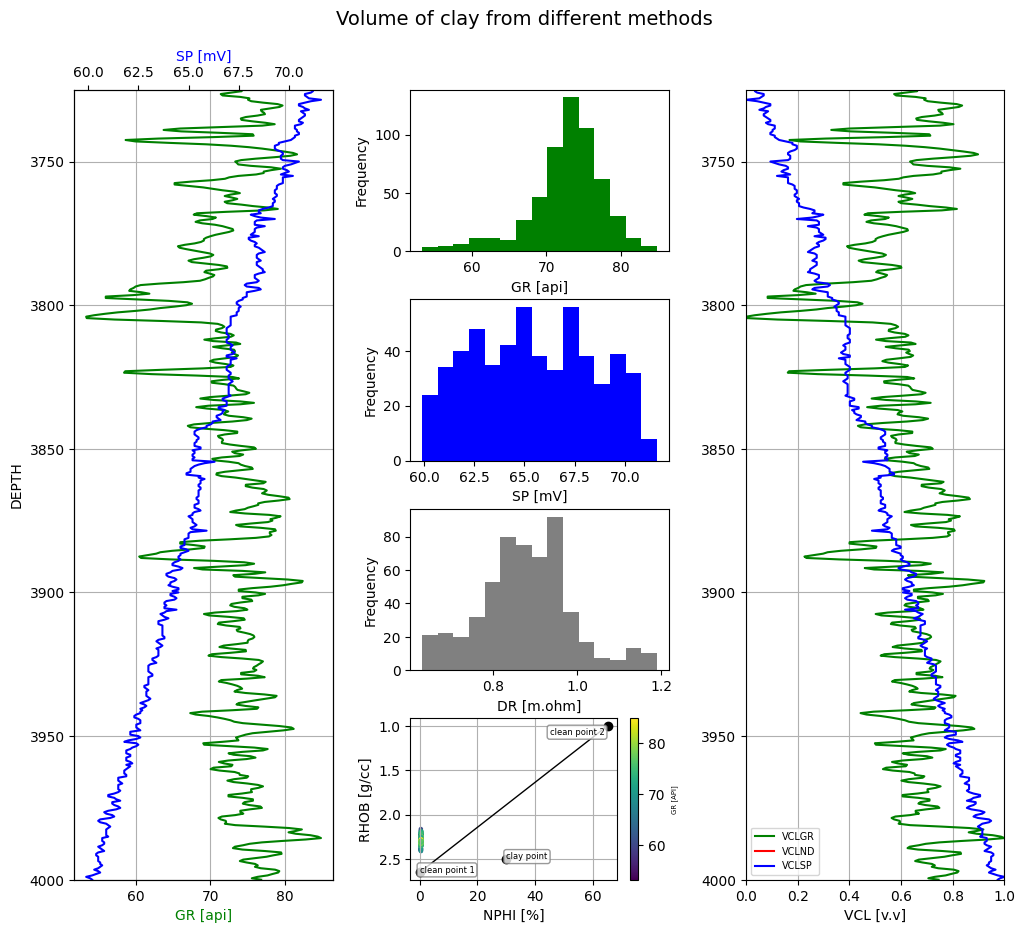

In [58]:
vcl_plot(logs, depth_start, depth_end,gr_clean,gr_clay,neut_clean1,den_clean1,neut_clean2,den_clean2,neut_clay,den_clay,sp_clean,sp_clay)

### **6.7 Choose the Best VCL**

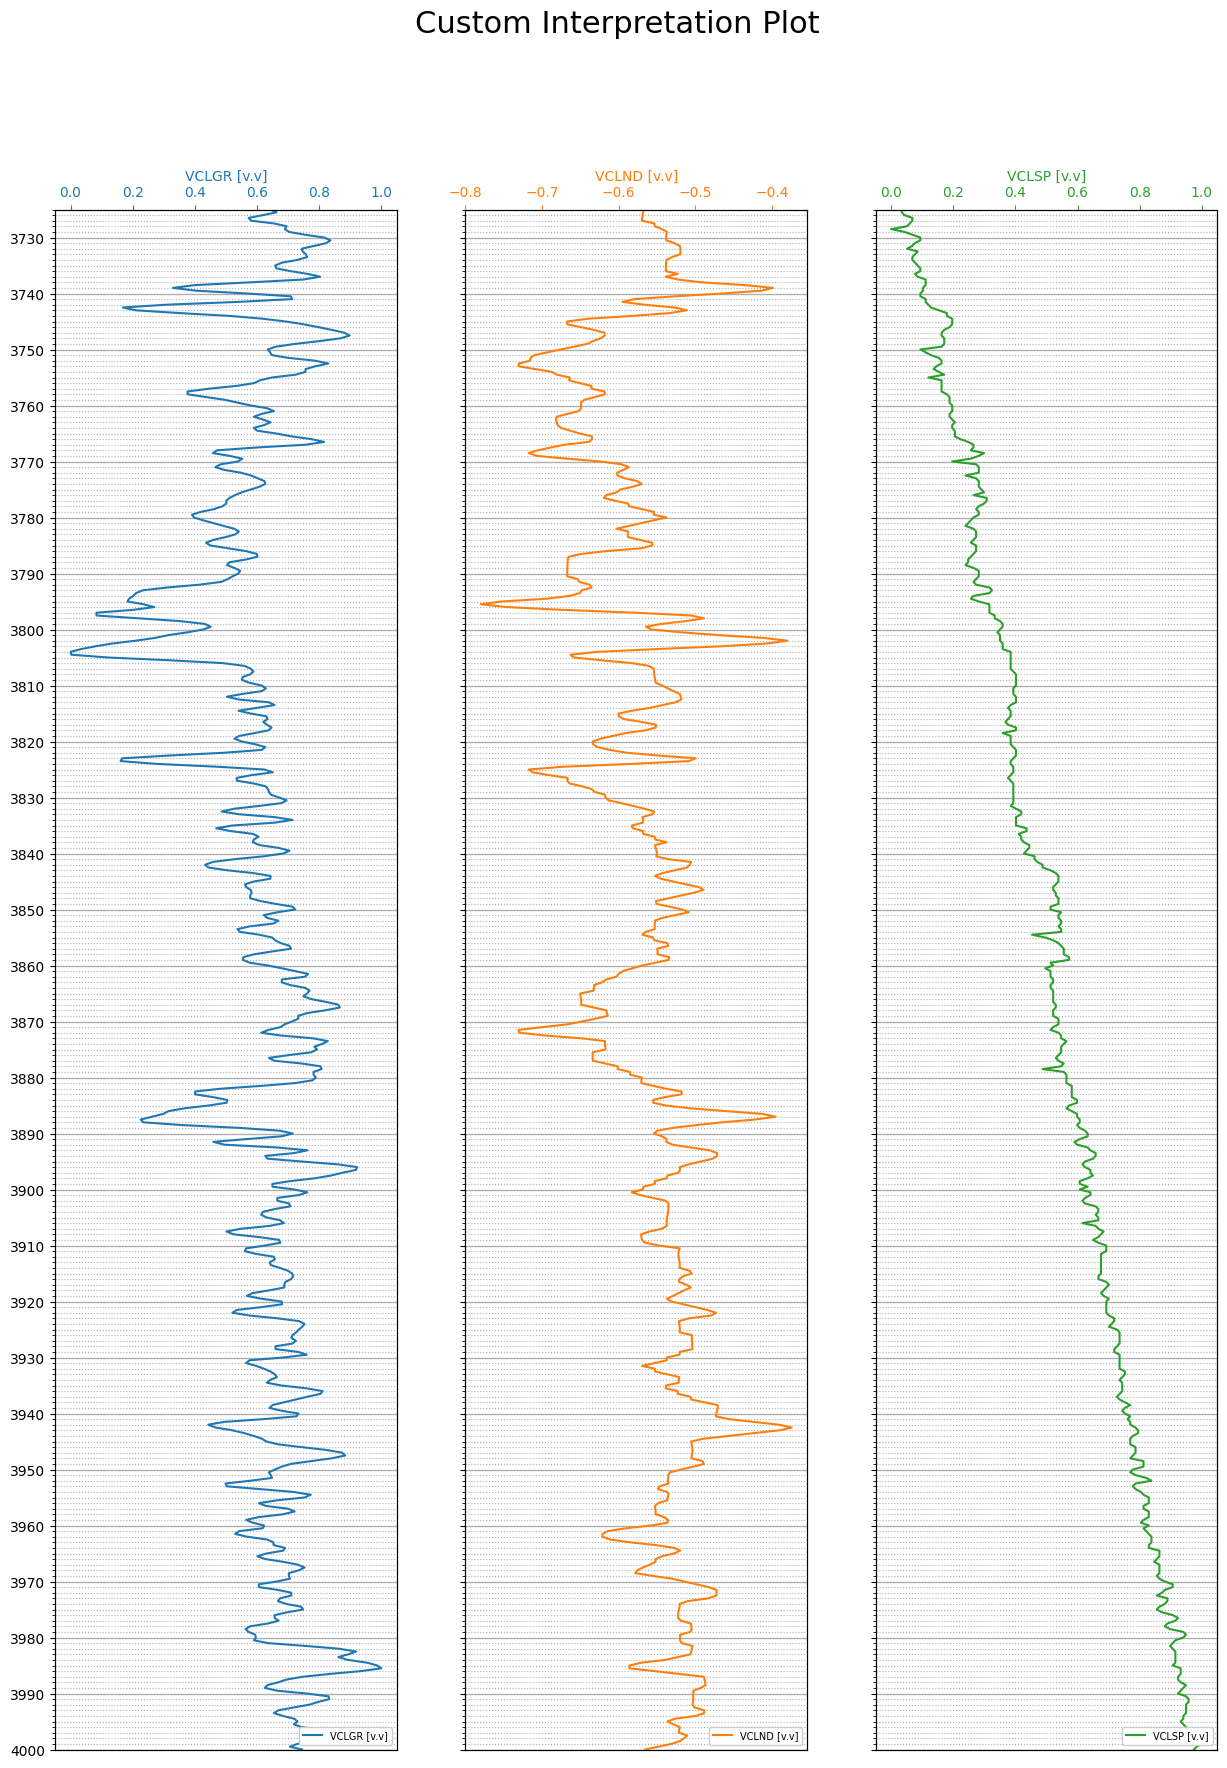

In [59]:
custom_interpretation_plot(logs, depth_start, depth_end, "VCLGR", "VCLND", "VCLSP", units=["v.v", "v.v", "v.v"])

To make the understanding easier, we will treat VCLGR as equivalent to VCL.
Alternatively, from 2 sub plot above, we can view vcl as the smallest value derived from various techniques, where VCL equals the minimum among VCLGR, VCLSP, and VCLND.

In [60]:
logs['VCL']=logs['VCLGR']

## **7. POROSITY CALCULATION**
There are three types of logs that can be used to estimate porosity: sonic, density, and neutron logs. Porosity can be determined using either individual or paired combinations of these logs. The possible combinations include neutron-density, neutron-sonic, and sonic-density.<br>
**Basic porosity formulas are:**
- Sonic:
    - Wyllie (Time Average)
    - Raymer-Hunt-Gardner
- Density
- Neutronic<br>

### **7.1. Shale Porosity Equation**
**Shale porosity with sonic Log:** <br>
$\phi_{shale[sonic]} = \frac{\Delta T_{sh}-\Delta T_{ma}}{\Delta T_{fl}-\Delta T_{ma}}$

**Shale porosity with density log:** <br>
$\phi_{shale[density]} = \frac{\rho _{sh}-\rho _{ma}}{\rho _{fl}-\rho _{ma}}$

*Formula Explanation:*
- $\phi_{shale[sonic]}$: Shale porosity with sonic Log.
- $\phi_{shale[density]}$: Shale porosity with density log.
- $\Delta T_{sh}$: Sonic transit time in shale.
- $\Delta T_{ma}$: Sonic transit time in matrix.
- $\Delta T_{fl}$: Sonic transit time in fluid.
- $\rho _{sh}$: Density in shale.
- $\rho _{ma}$: Density in matrix.
- $\rho _{fl}$: Density in fluid.

In [61]:
#Willie-TimeAverage
def phis_shale(dt_sh, dt_ma, dt_fl):
    phis_shale = (dt_sh-dt_ma)/(dt_fl-dt_ma)
    return phis_shale

In [62]:
def phid_shale(den_sh, den_ma, den_fl):
    phid_shale = (den_sh - den_ma) / (den_fl - den_ma)
    return phid_shale

### **7.2. Wyllie Time-Average Equation**
**Porosity in the part under review:** <br> 
$\phi_{[sonic][Wyllie]} = \frac{1}{cp}\times \frac{\Delta T_{log}-\Delta T_{ma}}{\Delta T_{fl}-\Delta T_{ma}}$

**Effective porosity:** <br>
$\phi_{corr[sonic][Wyllie]} = {\phi_{[sonic][Wyllie]}}-{v_{cl}\times\phi_{shale[sonic]}}$

*Formula Explanation:*
- $\phi_{[sonic][Wyllie]}$: Porosity in the part under review using Wyllie Time-Average equation.
- $\phi_{corr[sonic][Wyllie]}$: Effective porosity considering volume of clay.

In [63]:
def phis_w(dt_log, dt_ma, dt_fl, cp):
    phis_w=(1/cp)*(dt_log-dt_ma)/(dt_fl-dt_ma)
    return phis_w

In [64]:
def phis_w_sh_corr(dt_log, dt_ma, dt_fl, cp, dt_sh, vcl):
    phis_w_sh_corr = phis_w(dt_log,dt_ma,dt_fl,cp) - vcl*phis_shale(dt_sh,dt_ma,dt_fl)
    return phis_w_sh_corr

### **7.3. Raymer Hunt Gardner Equation**
**Porosity in the part under review:** <br>
$\phi_{[sonic][Raymer]} = \alpha\times \frac{\Delta T_{log}-\Delta T_{ma}}{\Delta T_{log}}$

**Effective porosity:** <br>
$\phi_{corr[sonic][raymer]} = {\phi_{[sonic][raymer]}}-{v_{cl}\times\phi_{shale[sonic]}}$

*Formula Explanation:*
- $\phi_{[sonic][Raymer]}$: Porosity in the part under review using Raymer Hunt Gardner equation.
- $\phi_{corr[sonic][raymer]}$: Effective porosity considering volume of clay.

In [65]:
#Raymer-Hunt-Gardner (the alpha(5/8) ranges from 0.625-0.70, 0.67-most, 0.60-gas reservoirs)
def phis_rhg(dt_log, dt_ma, alpha):
    phis_rhg=(alpha)*(dt_log-dt_ma)/(dt_log)
    return phis_rhg

In [66]:
def phis_rhg_sh_corr(dt_log, dt_ma, dt_sh, vcl,alpha,dt_fl):
    phis_rhg_sh_corr = phis_rhg(dt_log, dt_ma, alpha) - vcl * phis_shale(dt_sh, dt_ma, dt_fl)
    return phis_rhg_sh_corr

### **7.4. Density Equation**
**Porosity in the part under review:** <br>
$\phi_{[density]} = \frac{\rho_{log}-\rho_{ma}}{\rho_{fl}-\rho_{ma}}$

**Effective porosity:** <br>
$\phi_{corr[density]} = {\phi_{[density]}}-{v_{cl}\times\phi_{shale[density]}}$

*Formula Explanation:*
- $\phi_{[density]}$: Porosity in the part under review using density log.
- $\phi_{corr[density]}$: Effective porosity considering volume of clay.

In [67]:
#Density
def phid(den_log, den_ma, den_fl):
    phid = (den_log - den_ma) / (den_fl - den_ma)
    return phid

In [68]:
def phid_sh_corr(den_log, den_ma, den_fl, den_sh, vcl):
    phid_sh_corr = phid(den_log, den_ma, den_fl) - vcl * phid_shale(den_sh, den_ma, den_fl)
    return phid_sh_corr

### **7.5. Neutron Equation**
**Effective porosity:** <br>
$\phi_{[corr][neutron]} = \frac{nphi_{log}-vcl\times nphi_{shale}}{100}$

*Formula Explanation:*
- $\phi_{[corr][neutron]}$: Effective porosity using neutron log.
- $nphi_{log}$: Neutron porosity log value.
- $vcl$: Volume of clay.

In [69]:
# Neutron
def phin_sh_corr(neut, neut_sh, vcl):
    phin_sh_corr = (neut-vcl*neut_sh)/100
    return phin_sh_corr

### **7.6. Neutron-Density Equation**
$\phi_{[neutronxdensity]} = \frac{\phi_{nshc} + \phi_{dshc}}{2}$

$\phi_{[corr][neutronxdensity]} = \sqrt{\frac{\phi_{n}^2 + \phi_{d}^2}{2}}$

*Formula Explanation:*
- $\phi_{[neutronxdensity]}$: Porosity using neutron-density combination.
- $\phi_{[corr][neutronxdensity]}$: Effective porosity considering neutron-density combination.
- $\phi_{nshc}$, $\phi_{dshc}$: Neutron and density porosities in shale and clean formations.
- $\phi_{n}$, $\phi_{d}$: Neutron and density porosities.

In [70]:
#Neutron-Density
def phixnd(phinshc, phidshc):
    phixnd= (phinshc + phidshc) / 2
    return phixnd
def phixnd_gas_corr(phin, phid, phin_sh, phid_sh):
    phixnd_gas_corr= ((phin**2+phid**2)/2)**(0.5)    #for gas intervals (nphi<dphi = crossover)
    return phixnd_gas_corr

### **7.7. Resistivity Equation**
**7.7.1. Volume of Clay using Resistivity log:** <br>
$V_{rt} = \frac{rt_{clay}}{rt_{log}} \times \frac{rt_{clean} - rt_{log}}{rt_{clean} - rt_{clay}}$

- **Formula Explanation:**
  - $V_{rt}$: Volume of Clay using Resistivity log.
  - $rt_{clay}$: Resistivity in clay-rich formations.
  - $rt_{log}$: Resistivity log value.
  - $rt_{clean}$: Resistivity in clean formations.
  - $st_{clay}$: Saturation in clay-rich formations.

### **7.7. Define the Parameter for Porosity Calculation**


In [71]:
#Matrix, fluid and appropiate shales values must be declared in the next variables:
dt_ma, dt_fl, dt_sh, cp, alpha = 55.5, 188.0, 90.0, 1, 5/8
den_ma, den_fl, den_sh = den_clean1, den_clean2, den_clay

phis_sh=phis_shale(dt_sh, dt_ma, dt_fl)
phid_sh=phis_shale(den_sh, den_ma, den_fl)
phin_sh=45

### **7.8. All Porosity Calculation**


In [72]:
logs['PHISw']=phis_w(logs.DT, dt_ma, dt_fl, cp)
logs['PHISwshc']=phis_w_sh_corr(logs.DT, dt_ma, dt_fl, cp, dt_sh, logs.VCL).clip(0,1)

logs['PHISrhg']=phis_rhg(logs.DT, dt_ma, alpha)
logs['PHISrhgshc']=phis_rhg_sh_corr(logs.DT, dt_ma, dt_sh, logs.VCL,alpha,dt_fl).clip(0,1)

logs['PHID']=phid(logs.RHOB, den_ma, den_fl)
logs['PHIDshc']=phid_sh_corr(logs.RHOB, den_ma, den_fl, den_sh, logs.VCL).clip(0,1)

logs['PHIN']=logs.NPHI/100
logs['PHINshc']=phin_sh_corr(logs.NPHI, phin_sh, logs.VCL).clip(0,1)

logs['PHIxND']=phixnd(logs.PHINshc,logs.PHIDshc).clip(0,1)

### **7.9 Choose the Best PHIE**

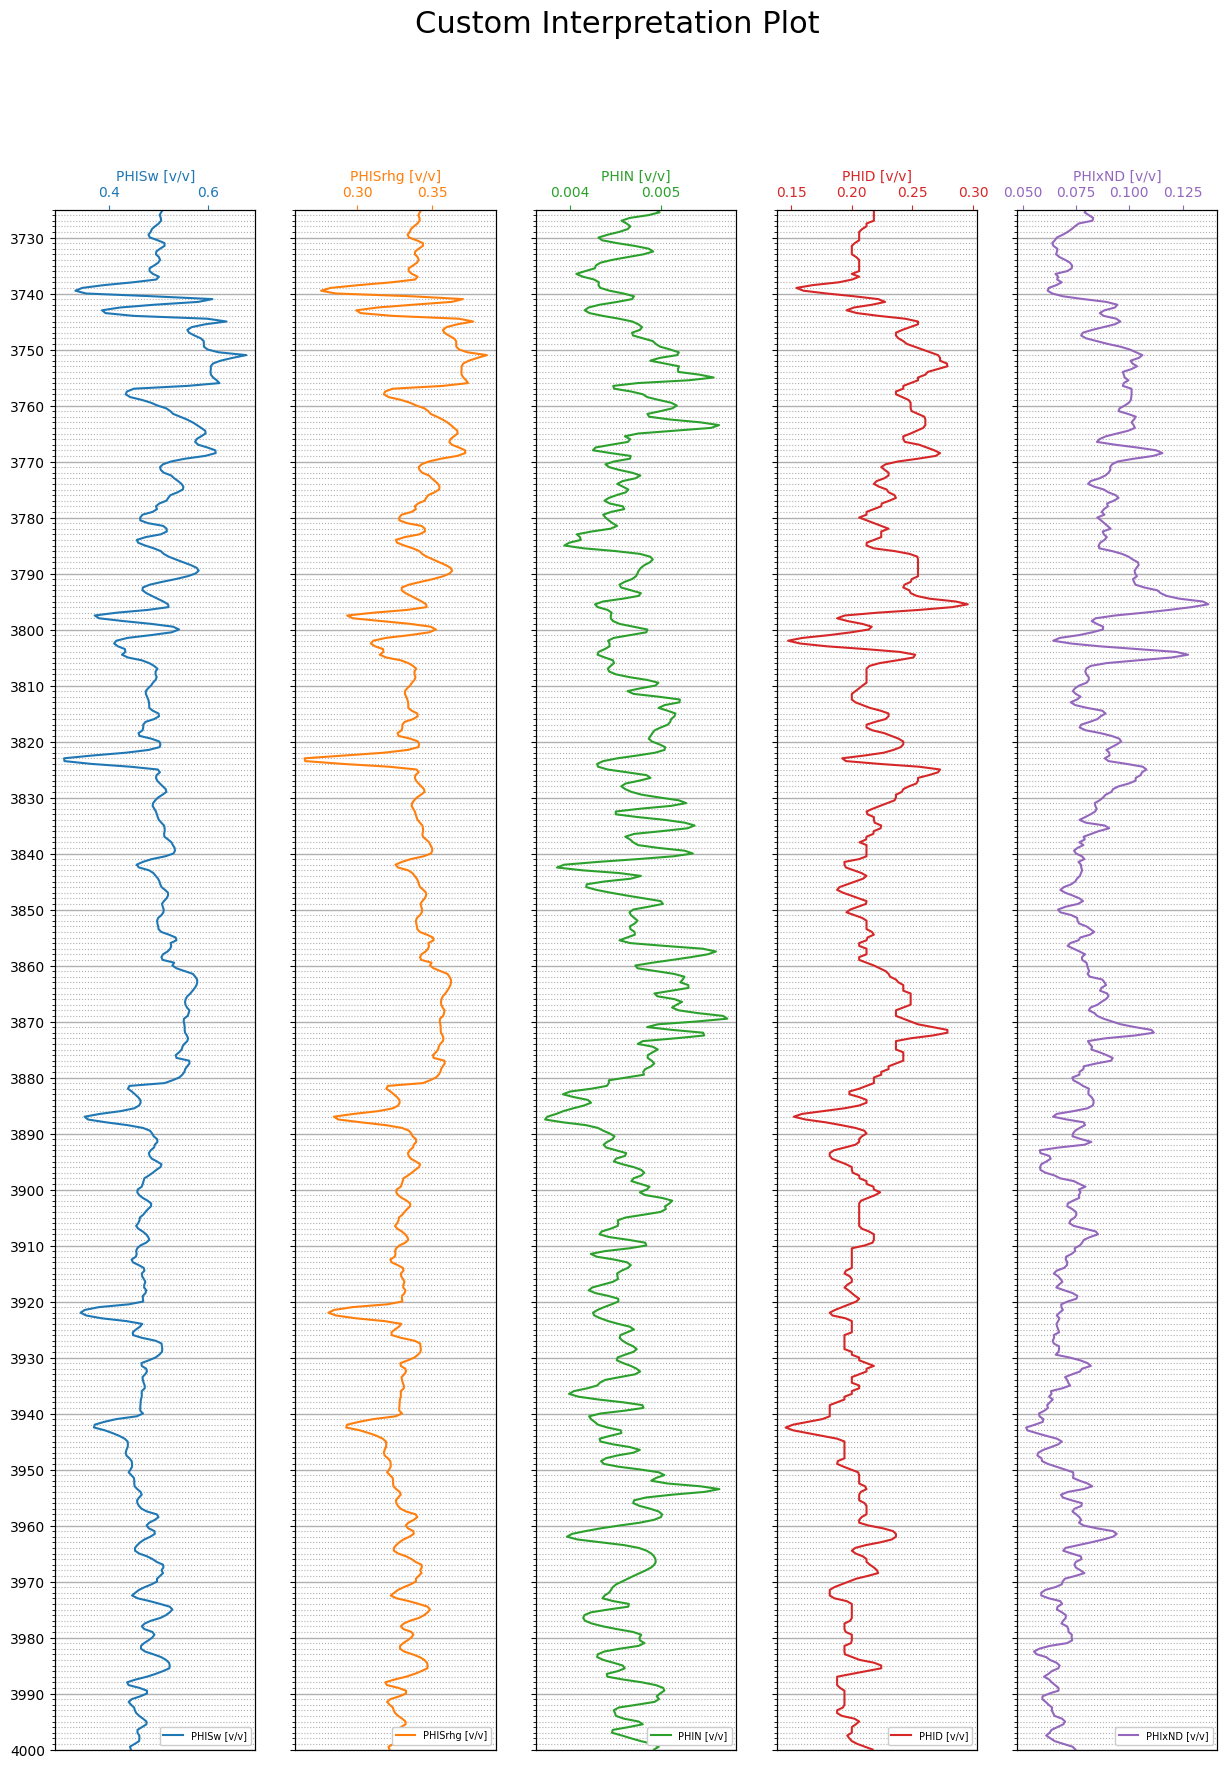

In [73]:
# Example usage:
custom_interpretation_plot(logs, depth_start, depth_end, "PHISw", "PHISrhg", "PHIN", "PHID", "PHIxND", units=["v/v", "v/v", "v/v", "v/v", "v/v"])

In [74]:
logs['PHIE']=logs['PHID']

## **8. WATER SATURATION CALCULATION**
Before calculating the water saturation will need a value for the Rw (Resistivity of water)<br>
**Resistivity of water:**
It can be determined from:
- Ater catalogs <br>
- DST test water analysis <br>
- Rw from SP (needs information about Rmud and ... ) <br>
- Rwa Method (Rw from a 100% water zone) <br>

### **8.1. Archie Water Sturation Equation**
Suppose we lack any prior knowledge of Rwater. In such cases, following the best approach involves utilizing a PICKETT graph. This graph takes on a logarithmic form derived from Archie's equation:

$Sw^{n} = \frac{a \times R_w}{R_t \times \phi^m}$

In [75]:
def sw_archie(Rw, Rt, Poro, a, m, n):
        F = a / (Poro**m)
        Sw_archie = (F * Rw/Rt)**(1/n)
        return Sw_archie

The equation can be transformed into a logarithmic expression and visualized on a log plot of RT against PHI:

$\log \phi = -\frac{1}{m} \log(R_t) - n \log(S_w) + \log(a\times R_w)$

In [76]:
def pickett_plot(logs, vcl_limit, a, rwa, m, n, z):
    plt.figure(figsize=(7,6))
    plt.title('Pickett Plot'+ ' for VCL < '+ str(int(vcl_limit*100)) + '%' + " and Rw = " + str(rwa) + " ohm.m")
    c = logs[z][logs.VCL<vcl_limit]
    plt.scatter(logs.DR[logs.VCL<vcl_limit], logs.PHIE[logs.VCL<vcl_limit],c=c, s=20, cmap="plasma")
    cbar = plt.colorbar()
    cbar.set_label(f'{z}')
    plt.xlim(0.1,1000)
    plt.ylim(0.01,1)
    plt.ylabel('PHIE [v/v]')
    plt.xlabel('DR [m.ohm]')
    plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')

    #calculate the saturation lines
    sw_plot=(1.0,0.8,0.6,0.4,0.2)
    phie_plot=(0.01,1)
    rt_plot=np.zeros((len(sw_plot),len(phie_plot)))

    for i in range (0,len(sw_plot)):
        for j in range (0,len(phie_plot)):
            rt_result=((a*rwa)/(sw_plot[i]**n)/(phie_plot[j]**m))
            rt_plot[i,j]=rt_result      
    for i in range(0,len(sw_plot)):
        plt.plot(rt_plot[i],phie_plot, label='SW '+str(int(sw_plot[i]*100))+'%')
        plt.legend (loc='best')

    plt.grid(True, which='both',ls='-',color='gray')

#### **8.1.1. Define the Paramater for Archie Water Saturation Calculation**

Firstly, it's important to establish the values for the variables: a, m, and n. To initiate this process, you might consider beginning with the values (a=1, m=2, n=2), which tend to yield favorable results across various rock types. In cases where the rock matrix contains a mixture of shale, it might be advisable to reduce the value of m to 1.8. 
- a, turtuosity factor
- m, cementation factor
- n, saturation exponent
- rwa, water resistivity
- vcl_limit, volume of clay upper limit for selction of data for graph

In [77]:
a = 1
m = 1.83
n = 1.7

#### **8.1.2. Choose the Water Resistivity**

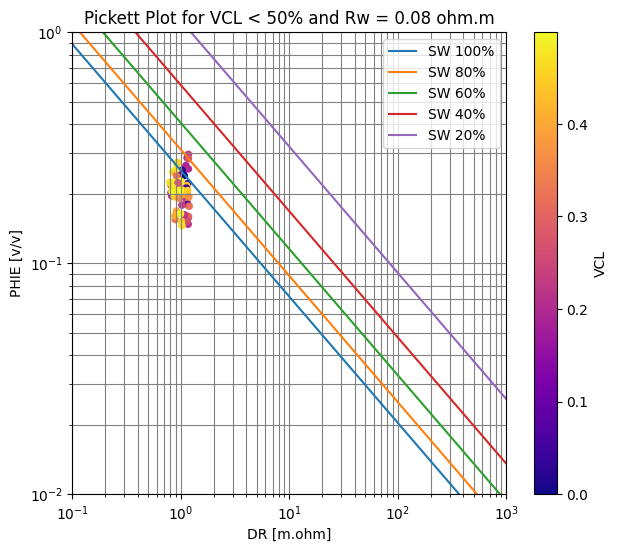

In [78]:
pickett_plot(logs, vcl_limit = 0.5, a = a, rwa = 0.08, m = m, n = n, z = "VCL")

The outcomes obtained from the Pickett plot indicate the presence of distinct intervals within two zones, warranting separate interpretation and analysis. To initiate the process, we will select an appropriate value for Rwa and utilize the Archie equation to compute the Sw curve.

Next, proceed to select the water resistivity, denoted as rwa. We will create a Pickett chart by plotting Resistivity against Porosity. To curate the data for this plot, focus exclusively on the reservoir formations while excluding the shaly intervals. This can be accomplished by adjusting the vcl_limit variable, which represents the volume of clay.

In [79]:
Rw = 0.08 #adjusted selected water resistivity

#### **8.1.3. Calculate the Water Saturation using Archie**
and call it in order to have the result of saturation Swa. Clip the results between (0,1).

In [80]:
logs['SWarchie']=(sw_archie(Rw,logs.DR,logs.PHIE,a,m,n)).clip(0,1)

In [81]:
logs["SWarchie"] = logs["SWarchie"].clip(0, 1)

Calculate the BVW (bulk volume of water):

In [82]:
logs['BVW']=logs['SWarchie']*logs['PHIE']
logs['matrix']=1-logs.VCL-logs.PHIE

### **8.2 Waxman-Smits Water Sturation Equation**

$B_{max} = 51.31\times log(T+460)-317.2$ <br>
$B = (1 - \frac{0.83}{exp(0.5/Rw)}) \times B_{max}$ <br>

$F = \frac{a}{\phi^m}$ <br>
$Swi = (F\times\frac{Rw}{Rt})^{\frac{1}{n}}$

**Iterate** <br>
$Sw = (\frac{F}{\frac{Rt}{(1 / Rw + (b * Qv / Swi))}}) ^ {\frac{1}{n}}$ <br>

$Sw = (F / Rt / (1 / Rw + (b * Qv / Swi))) ^ {\frac{1}{n}}$

In [83]:
def sw_waxman(Rw, Qv, a, m, n, Temp, Rt, Phi):
    Sw, Swi = 0.0, 0.0
    Bmax = 51.31 * math.log(Temp + 460) - 317.2
    b = (1 - 0.83 / math.exp(0.5 / Rw)) * Bmax
    F = a / (Phi ** m)
    
    Swi = (F * Rw / Rt) ** (1 / n)

    while abs(Sw - Swi) > 0.01:
        Sw = (F / Rt / (1 / Rw + (b * Qv / Swi))) ** (1 / n)
        Swi = Sw

    return Sw

#### **8.2.1. Define the Thermal Gradient for Waxman-Smits Water Saturation Calculation**

In [84]:
#Geothermal Gradient
mid_perf = 13950  #TVD
BHT_mid_perf = 192 #Fahrenheit
T_surf = 60 #Fahrenheit
T_gradient = (BHT_mid_perf-T_surf)/(mid_perf) #Fahrenheit/ft

#### **8.2.2. By using the same parameters as Archie, calculate the Wwter saturation using Waxman-Smits**


In [85]:
logs["CEC"] = -47.619 * logs["VCL"] ** 2.0 + 61.429 * logs["VCL"]

In [86]:
logs["T"] = T_surf + T_gradient * logs["DEPT"]

In [87]:
print(logs['PHIE'])

7450    0.218182
7451    0.218182
7452    0.218182
7453    0.218182
7454    0.218182
          ...   
7996    0.197939
7997    0.200000
7998    0.204485
7999    0.210788
8000    0.217091
Name: PHIE, Length: 551, dtype: float64


In [88]:
logs['SWwaxman'] = logs.apply(lambda row: sw_waxman(Rw, row['CEC'], a, m, n, row['T'], row['DR'], row['PHIE']), axis=1)

In [89]:
logs["SWwaxman"] = logs["SWwaxman"].clip(0,1)

### **8.3 Poupon-Laveaux (Indonesia) Water Sturation Equation**

In [90]:
def sw_indonesia(Rw, Rt, Poro, a, m, n, vcl,rsh):
        Sw_indonesia = ((1/Rt)/(((vcl**(1-(0.5*vcl)))/(rsh**0.5))+(((Poro**m)/(a*Rw))**0.5)))**(2/n)
        return Sw_indonesia

In [91]:
logs["SWindonesia"] = logs.apply(lambda row: sw_indonesia(Rw, row['DR'], row['PHIE'], a, m, n, row['VCL'],rsh=100), axis=1)

In [92]:
logs["SWindonesia"] = logs["SWindonesia"].clip(0,1)

### **8.4 Simandoux SW**

In [93]:
def sw_simandoux(Rw, Rt, Vsh, Poro, a, m, n, Rsh):
    var1 = (Poro**m)
    var2 = (Vsh/Rsh)**2
    Sw_modsim = ((a/2)*(Rw/var1)*(math.sqrt(var2+(4/a)*(var1/Rw)*(1/Rt))-(Vsh/Rsh)))**(2/n)

    return Sw_modsim

In [94]:
logs["SWsimandoux"] = logs.apply(lambda row: sw_simandoux(row['RW'], row['DR'], row['VSH'], row['PHIE'], a, m, n, Rsh=100), axis=1)

In [95]:
logs["SWsimandoux"] = logs["SWsimandoux"].clip(0,1)

### **8.5 Choose the Best SW**

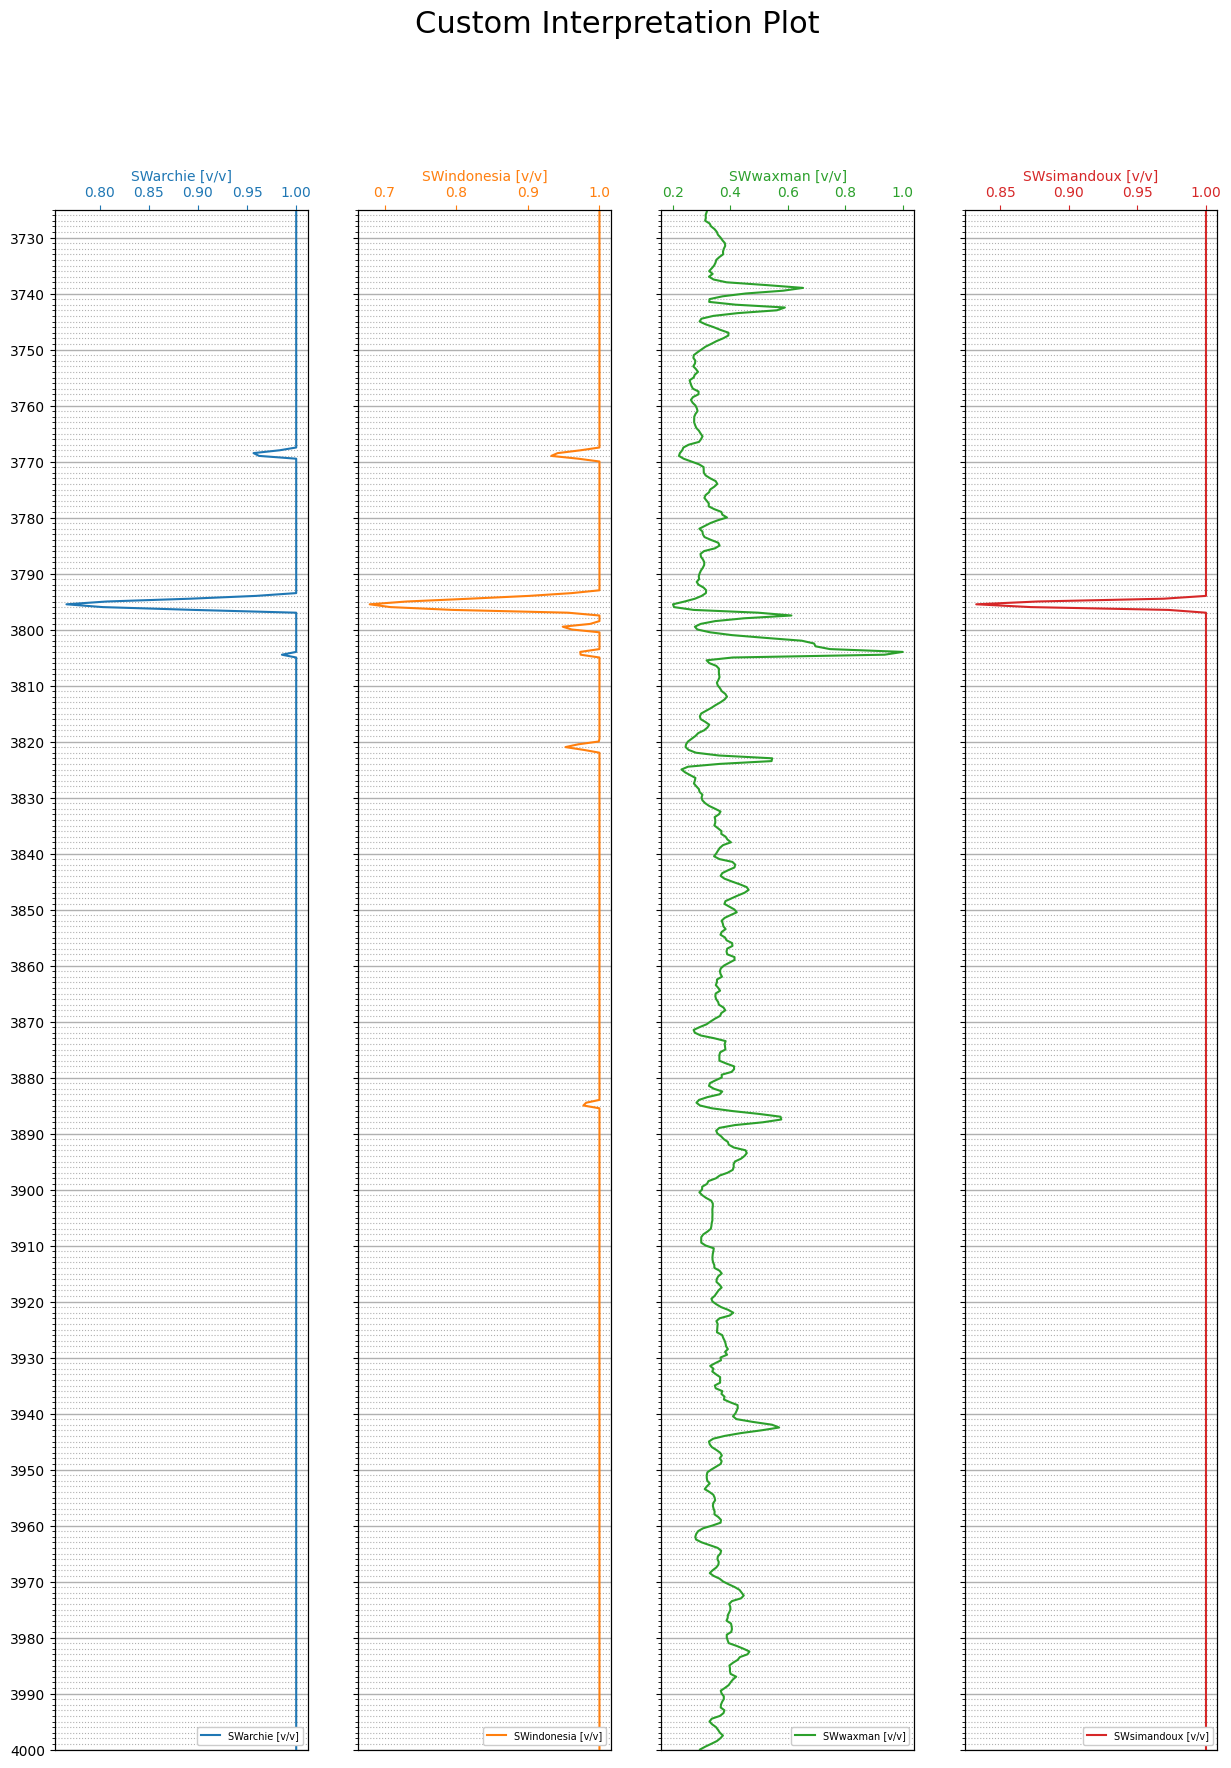

In [96]:
custom_interpretation_plot(logs, depth_start, depth_end, "SWarchie", "SWindonesia", "SWwaxman", "SWsimandoux", units=["v/v", "v/v", "v/v", "v/v"])

## **9. PERMEABILITY CALCULATION**

In [97]:
def perm_timur(phie,sw):
    perm = ((93*(phie**2.2))/sw)**2
    return perm

In [98]:
print(logs.columns)

Index(['DEPT', 'RW', 'WELL', 'CALI', 'DT', 'GR', 'MR', 'DR', 'SR', 'NPHI',
       'RHOB', 'SP', 'VSH', 'core_por', 'core_perm', 'VCLGR', 'VCLND', 'VCLSP',
       'VCL', 'PHISw', 'PHISwshc', 'PHISrhg', 'PHISrhgshc', 'PHID', 'PHIDshc',
       'PHIN', 'PHINshc', 'PHIxND', 'PHIE', 'SWarchie', 'BVW', 'matrix', 'CEC',
       'T', 'SWwaxman', 'SWindonesia', 'SWsimandoux'],
      dtype='object')


In [99]:
logs['PERMtimur'] = logs.apply(lambda row: perm_timur(row['PHIE'],row['SWarchie']), axis=1)

In [100]:
#drop logs["perm"] above 1000
logs = logs[logs["PERMtimur"] < 1000]

## **10. DISPLAY THE INTERPRETATION PLOT**
Create a plot template and add the results of volume of clay, saturation, permeability, and porosity.

In [101]:
def interpretation_plot(logs, depth_start, depth_end, GR_min, GR_max, CALI_min, CALI_max, SP_min, SP_max, DR_min, DR_max, MR_min, MR_max, SR_min, SR_max, RHOB_min, RHOB_max, NPHI_min, NPHI_max, DT_min, DT_max, waxman,perm,fill):   
    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(12,20), sharey=True)
    fig.suptitle("Interpretation Plot", fontsize=22)
    fig.subplots_adjust(top=0.85,wspace=0.2)

    #General setting for all axis
    for axes in ax:
        axes.set_ylim (depth_start,depth_end)
        axes.invert_yaxis()
        axes.yaxis.grid(True, which='minor', linestyle=':')
        axes.yaxis.grid(True, which='major', linestyle='-', linewidth='1')
        axes.yaxis.set_major_locator(ticker.MultipleLocator(10))
        axes.yaxis.set_minor_locator(ticker.MultipleLocator(1))
        axes.get_xaxis().set_visible(False)  


    #1st track: GR, SP, CALI track
    ax01=ax[0].twiny()
    if SP_min != "auto" and SP_max != "auto":
        ax01.set_xlim(SP_min,SP_max)
    ax01.plot(logs.SP, logs.DEPT, label='SP[mV]', color='blue')
    ax01.set_xlabel('SP[mV]',color='blue')    
    ax01.tick_params(axis='x', colors='blue')
        
    ax02=ax[0].twiny()
    if CALI_min != "auto" and CALI_max != "auto":
        ax02.set_xlim(CALI_min,CALI_max)
    ax01.grid(True)
    ax02.plot(logs.CALI, logs.DEPT, '--', label='CALI[in]', color='black') 
    ax02.spines['top'].set_position(('outward',40))
    ax02.set_xlabel('CALI[in]',color='black')    
    ax02.tick_params(axis='x', colors='black')
        
    ax03=ax[0].twiny()
    if GR_min != "auto" and GR_max != "auto":
        ax03.set_xlim(GR_min,GR_max)
    ax03.plot(logs.GR, logs.DEPT, label='GR[api]', color='green') 
    ax03.spines['top'].set_position(('outward',80))
    ax03.set_xlabel('GR[api]',color='green')    
    ax03.tick_params(axis='x', colors='green')



    #2nd track: Resistivities
    ax11=ax[1].twiny()
    if DR_min != "auto" and DR_max != "auto":
        ax11.set_xlim(DR_min,DR_max)
    ax11.set_xscale('log')
    ax11.grid(True, which="both")
    ax11.spines['top'].set_position(('outward',80))
    ax11.set_xlabel('DR[m.ohm]', color='red')
    ax11.plot(logs.DR, logs.DEPT, label='DR[m.ohm]', color='red')
    ax11.tick_params(axis='x', colors='red')    

    ax12=ax[1].twiny()
    if MR_min != "auto" and MR_max != "auto":
        ax12.set_xlim(MR_min,MR_max)
    ax12.set_xscale('log')
    ax12.plot(logs.MR, logs.DEPT, label='MR[m.ohm]', color='purple') 
    ax12.spines['top'].set_position(('outward',40))
    ax12.set_xlabel('MR[m.ohm]', color='purple')    
    ax12.tick_params(axis='x', colors='purple')
        
    ax13=ax[1].twiny()
    if SR_min != "auto" and SR_max != "auto":
        ax13.set_xlim(SR_min,SR_max)
    ax13.set_xscale('log')
    ax13.plot(logs.SR, logs.DEPT, '--',label='SR[m.ohm]', color='black') 
    ax13.spines['top'].set_position(('outward',0))
    ax13.set_xlabel('SR[m.ohm]',color='black')
    ax13.tick_params(axis='x', colors='black')



    #3rd track: DT, RHOB, NPHI track
    ax21=ax[2].twiny()
    ax21.grid(True)
    if DT_min != "auto" and DT_max != "auto":
        ax21.set_xlim(DT_min,DT_max)
    ax21.spines['top'].set_position(('outward',0))
    ax21.set_xlabel('DT[us/ft]')
    ax21.plot(logs.DT, logs.DEPT, label='DT[us/ft]', color='blue')
    ax21.set_xlabel('DT[us/ft]', color='blue')    
    ax21.tick_params(axis='x', colors='blue')
        
    ax22=ax[2].twiny()
    if NPHI_min != "auto" and NPHI_max != "auto":
        ax22.set_xlim(NPHI_min,NPHI_max)
    ax22.invert_xaxis()
    ax22.plot(logs.NPHI, logs.DEPT, label='NPHI[%]', color='green') 
    ax22.spines['top'].set_position(('outward',40))
    ax22.set_xlabel('NPHI[%]', color='green')    
    ax22.tick_params(axis='x', colors='green')
        
    ax23=ax[2].twiny()
    if RHOB_min != "auto" and RHOB_max != "auto":
        ax23.set_xlim(RHOB_min,RHOB_max)
    ax23.plot(logs.RHOB, logs.DEPT ,label='RHOB[g/cc]', color='red') 
    ax23.spines['top'].set_position(('outward',80))
    ax23.set_xlabel('RHOB[g/cc]',color='red')
    ax23.tick_params(axis='x', colors='red')



    #4th track: SW
    ax31=ax[3].twiny()
    ax31.grid(True)
    ax31.set_xlim(1,0)
    if fill == "yes":
        ax31.fill_betweenx(logs.DEPT,logs.SWarchie,logs[waxman],color='lightgreen',label='waxman - archie')
        ax31.fill_betweenx(logs.DEPT,logs.SWarchie,logs.SWindonesia,color='lightblue',label='indonesia - archie')
        ax31.fill_betweenx(logs.DEPT,logs.SWarchie,logs.SWsimandoux,color='pink',label='simandoux - archie')
    ax31.plot(logs.SWarchie, logs.DEPT, label='SW[Archie]', color='black',linewidth=1)
    ax31.spines['top'].set_position(('outward',0))
    ax31.set_xlabel('SW Archie [frac]', color='black')    
    ax31.tick_params(axis='x', colors='black')

    ax32=ax[3].twiny()
    ax32.set_xlim(1,0)
    ax32.plot(logs[waxman], logs.DEPT, label="SW[Waxman]",color="red")
    ax32.spines['top'].set_position(('outward',40))
    ax32.set_xlabel('SW Waxman [frac]', color='red')    
    ax32.tick_params(axis='x', colors='red')
    
    ax33=ax[3].twiny()
    ax33.set_xlim(1,0)
    ax33.plot(logs["SWindonesia"], logs.DEPT, label="SW[Indonesia]",color="blue")
    ax33.spines['top'].set_position(('outward',80))
    ax33.set_xlabel('SW Indonesia [frac]', color='blue')    
    ax33.tick_params(axis='x', colors='blue')       

    ax34=ax[3].twiny()
    ax34.set_xlim(1,0)
    ax34.plot(logs["SWsimandoux"], logs.DEPT, label="SW[simandoux]",color="green")
    ax34.spines['top'].set_position(('outward',120))
    ax34.set_xlabel('SW simandoux [frac]', color='green')    
    ax34.tick_params(axis='x', colors='green')


    #4th track: Permeability
    ax41=ax[4].twiny()
    ax41.plot(logs[perm], logs.DEPT, label="perm",color="green")
    ax41.spines['top'].set_position(('outward',0))
    ax41.set_xlabel('PERM [mD]', color='green')    
    ax41.tick_params(axis='x', colors='green')
    
    ax42=ax[4].twiny()
    ax42.scatter(core_selected_data.core_perm, core_selected_data.DEPT, label='C_PERM', color='red',linewidths=0.5)
    ax42.spines['top'].set_position(('outward',40))
    ax42.set_xlabel('PERM-CORE', color='red')    
    ax42.tick_params(axis='x', colors='red')



    #5th track: PHIE, BVW
    ax51=ax[5].twiny()
    ax51.grid(True)
    ax51.set_xlim(1,0)
    ax51.plot(logs.PHIE, logs.DEPT, label='PHIE', color='black', linewidth=0.5, alpha=0.5)
    ax51.fill_betweenx(logs.DEPT,0,logs.BVW,color='lightblue', alpha=0.5)
    ax51.spines['top'].set_position(('outward',0))
    ax51.set_xlabel('PHIE-LOG', color='black')    
    ax51.tick_params(axis='x', colors='black')

    ax52=ax[5].twiny()
    ax52.set_xlim(1,0)
    ax52.plot(logs.BVW, logs.DEPT, label='BVW', color='black', alpha=0.5)
    ax52.fill_betweenx(logs.DEPT,logs.PHIE, logs.BVW,color='green',alpha=0.2)
    ax52.scatter(core_selected_data.core_por, core_selected_data.DEPT, label='C_PHIE', color='red',linewidths=0.5)
    ax52.spines['top'].set_position(('outward',40))
    ax52.set_xlabel('BVW', color='black')    
    ax52.tick_params(axis='x', colors='black')

    ax53=ax[5].twiny()
    ax53.set_xlim(1,0)
    ax53.scatter(core_selected_data.core_por, core_selected_data.DEPT, label='C_PHIE', color='red',linewidths=0.5)
    ax53.spines['top'].set_position(('outward',80))
    ax53.set_xlabel('PHIE-CORE', color='red')    
    ax53.tick_params(axis='x', colors='red')



    #6th track: PHIE, MATRIX, VCL
    ax60=ax[6].twiny()
    ax60.set_xlim(1,0)
    ax60.spines['top'].set_position(('outward',0))
    ax60.plot(logs.PHIE, logs.DEPT, label='PHIE', color='black',linewidth=0.5)
    ax60.set_xlabel('Porosity', color='blue')    
    ax60.tick_params(axis='x', colors='blue')

    ax61=ax[6].twiny()
    ax61.set_xlim(0,1)
    ax61.spines['top'].set_position(('outward',40))
    ax61.plot(logs.VCL, logs.DEPT, label='VCL', color='green',linewidth=0.5)
    ax61.set_xlabel('VClay', color='green')    
    ax61.tick_params(axis='x', colors='green')

    ax62=ax[6].twiny()
    ax62.set_xlim(1,0)
    ax62.spines['top'].set_position(('outward',80))
    ax62.fill_betweenx(logs.DEPT,0,logs.PHIE,color='lightgray',label='porosity')
    ax62.fill_betweenx(logs.DEPT,logs.PHIE,1-logs.VCL,color='orange',label='matrix')
    ax62.fill_betweenx(logs.DEPT,1-logs.VCL,1,color='lightgreen',label= 'Vclay')
    ax62.set_xlabel('Matrix', color='orange')  
    ax62.tick_params(axis='x', colors='orange')
    ax62.legend(loc='lower left')


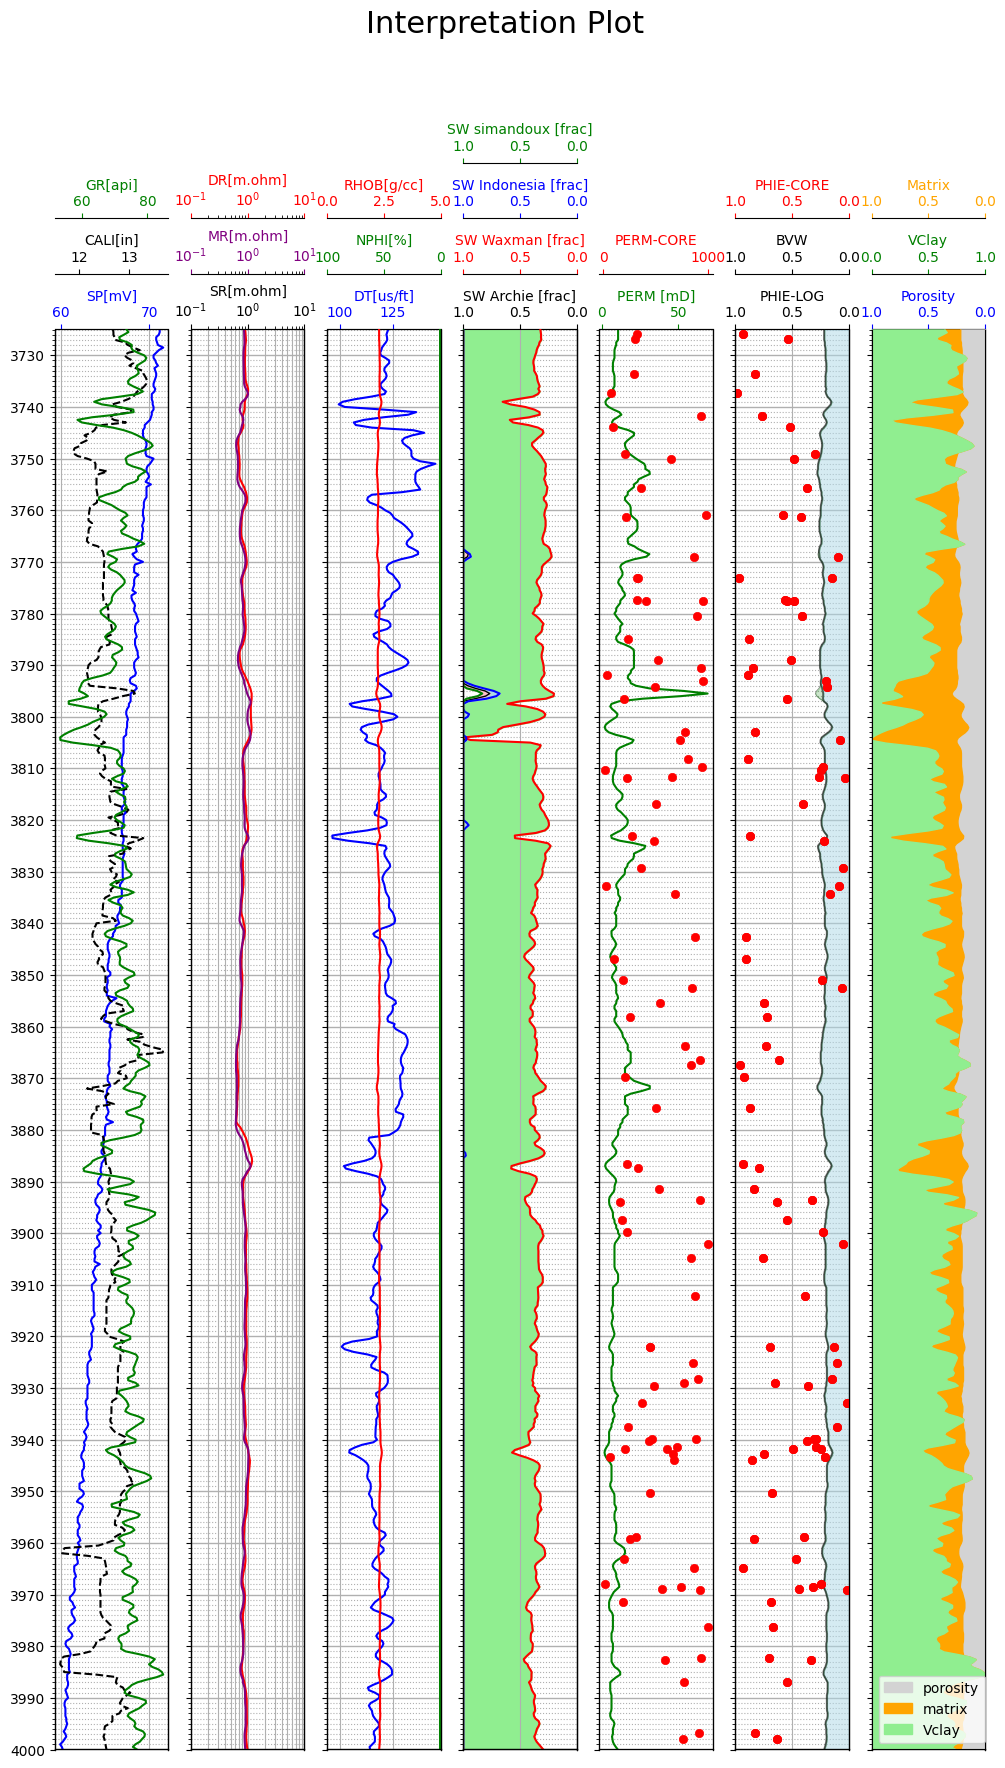

In [102]:
NPHI_max = 100
NPHI_min = 0
interpretation_plot(
    logs,
    depth_start,
    depth_end, 
    SP_min,
    SP_max,
    CALI_min,
    CALI_max,
    GR_min,
    GR_max,
    DR_min,
    DR_max,
    MR_min,
    MR_max,
    SR_min,
    SR_max,
    RHOB_min,           
    RHOB_max,                  
    NPHI_min,                  
    NPHI_max,
    DT_min,
    DT_max,
    "SWwaxman",
    "PERMtimur",
    "yes"
    )

In [103]:
top_clean = 3875
bottom_clean = 3885
mean_waxman = logs[(logs['DEPT'] >= top_clean) & (logs['DEPT'] <= bottom_clean)]["SWwaxman"].mean()
mean_archie = logs[(logs['DEPT'] >= top_clean) & (logs['DEPT'] <= bottom_clean)]["SWarchie"].mean()
SW_coef = mean_archie/mean_waxman

In [104]:
logs["SWwaxman_corrected"] = logs["SWwaxman"] * SW_coef

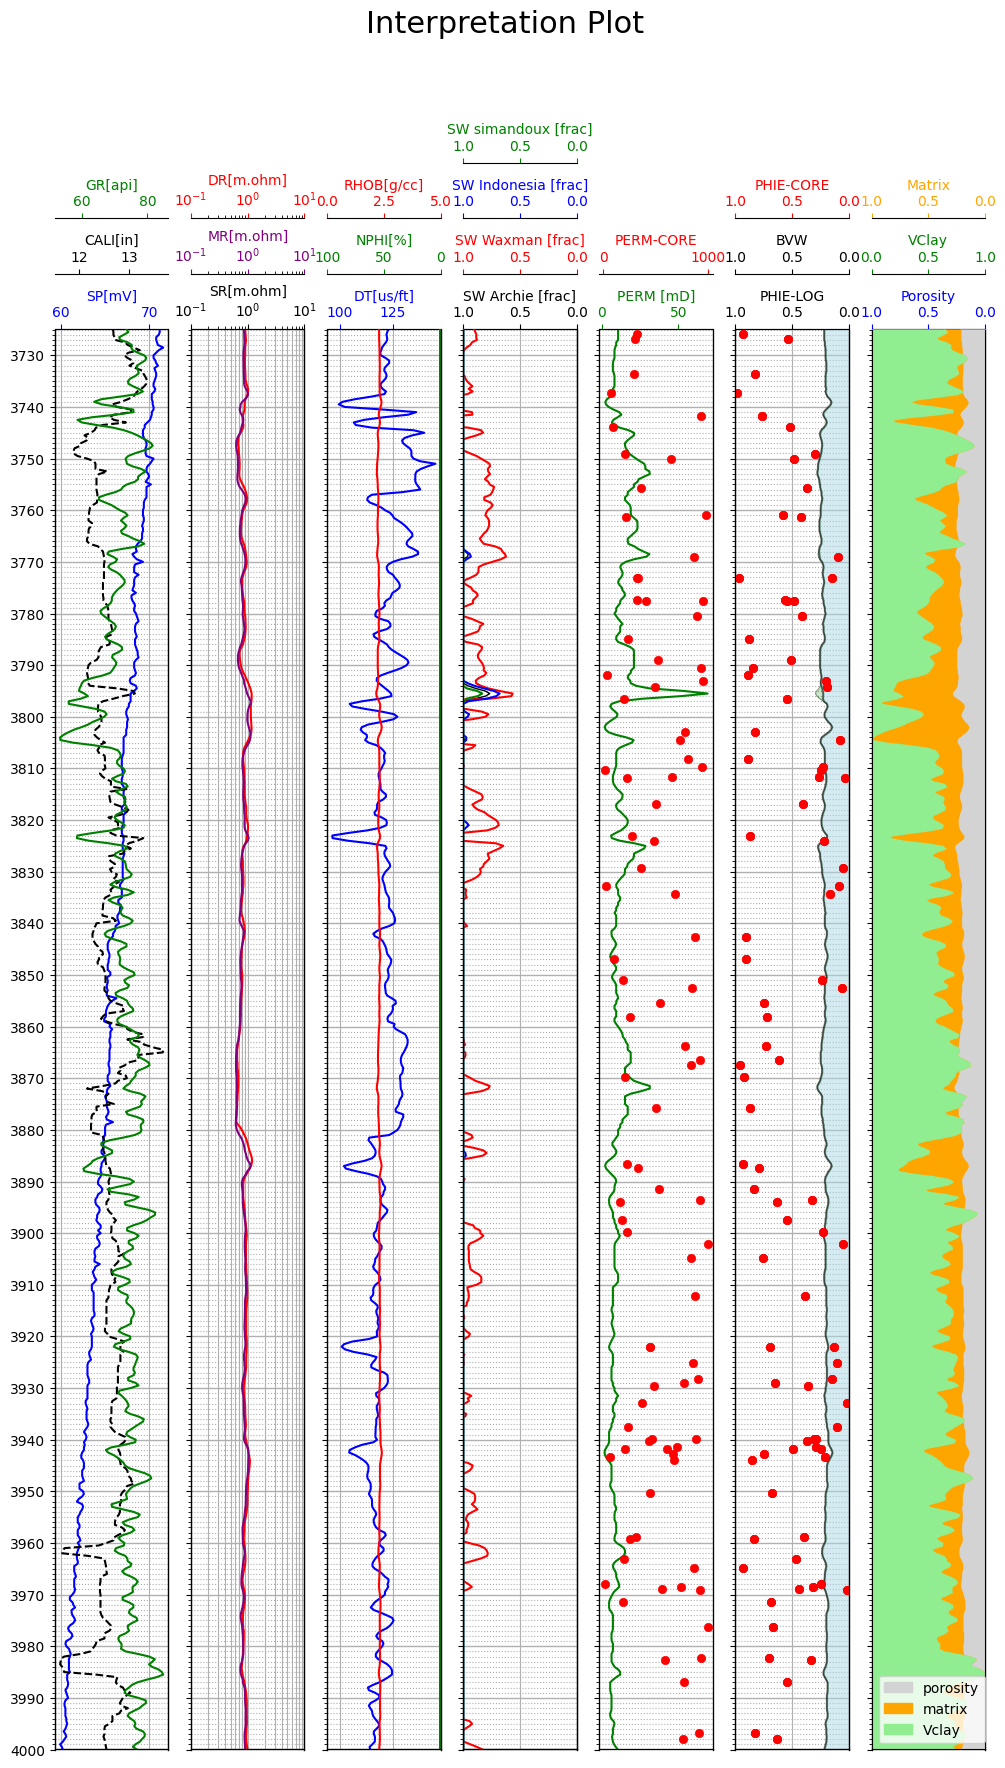

In [105]:
interpretation_plot(
    logs,
    depth_start,
    depth_end, 
    SP_min,
    SP_max,
    CALI_min,
    CALI_max,
    GR_min,
    GR_max,
    DR_min,
    DR_max,
    MR_min,
    MR_max,
    SR_min,
    SR_max,
    RHOB_min,           
    RHOB_max,                  
    NPHI_min,                  
    NPHI_max,
    DT_min,
    DT_max,
    "SWwaxman_corrected",
    "PERMtimur",
    "no"
    )

In [106]:
# Specify the file path where you want to save the Excel file
file_path = "output1.xlsx"

# Export the DataFrame to an Excel file
logs.to_excel(file_path, index=False)  # Set index=False to exclude the index column

print(f"DataFrame has been exported to {file_path}")


DataFrame has been exported to output1.xlsx


## **11. OTHER**

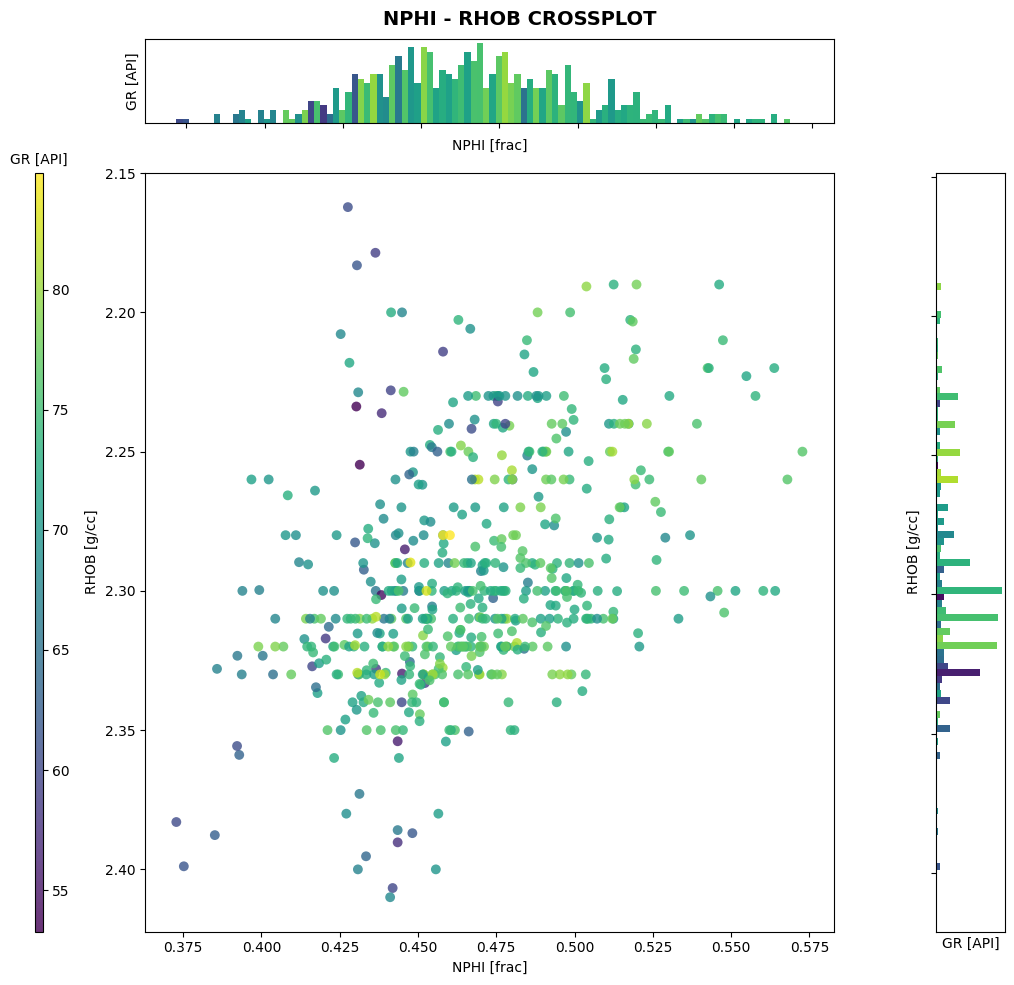

In [107]:
crossplott(logs,'NPHI','RHOB',"GR","frac","g/cc","API")

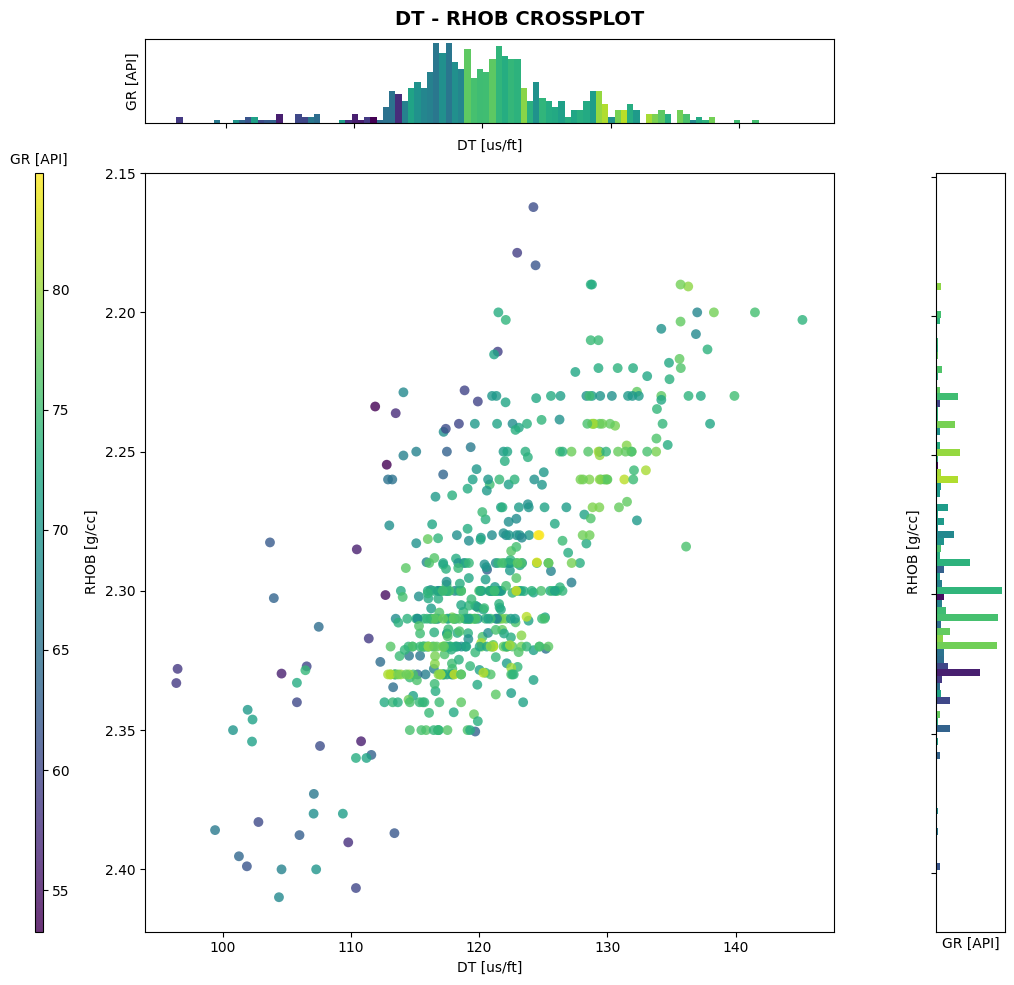

In [108]:
crossplott(logs,'DT','RHOB',"GR","us/ft","g/cc","API")

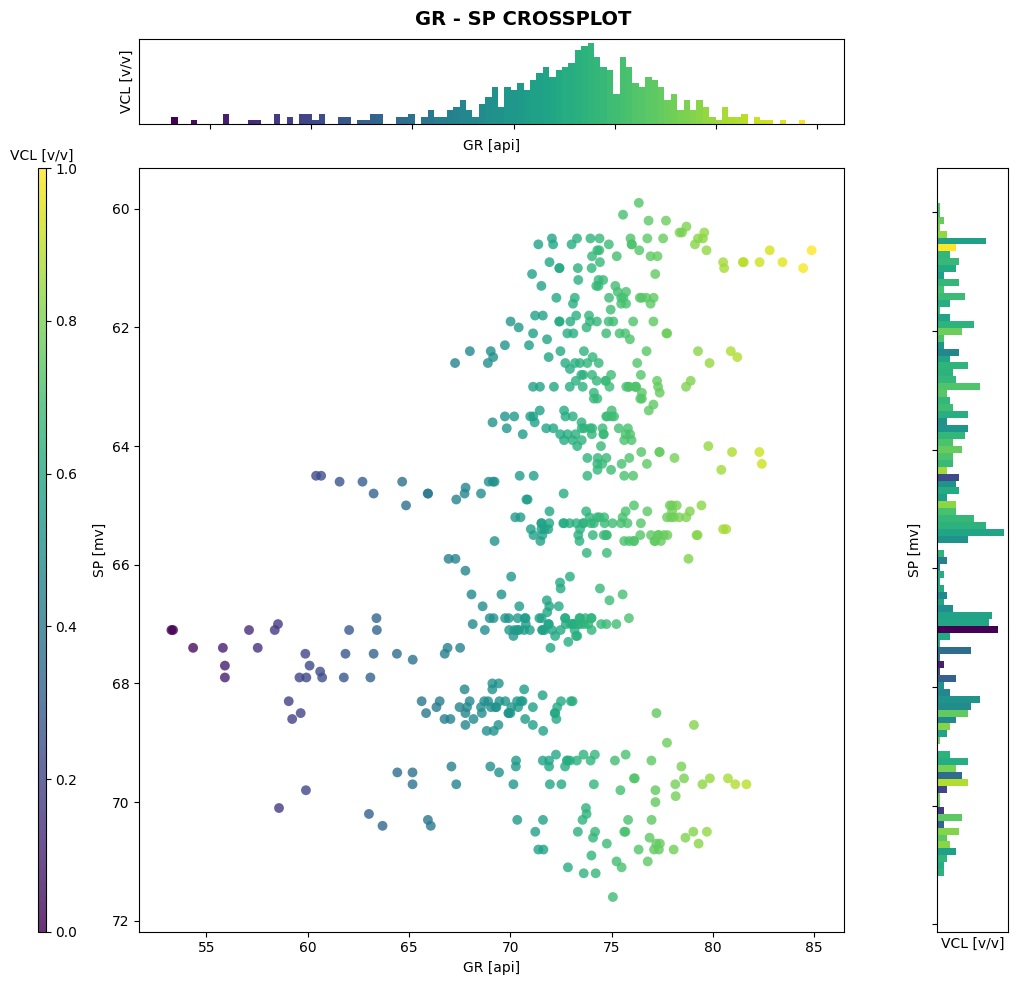

In [109]:
crossplott(logs,'GR','SP',"VCL","api","mv","v/v")

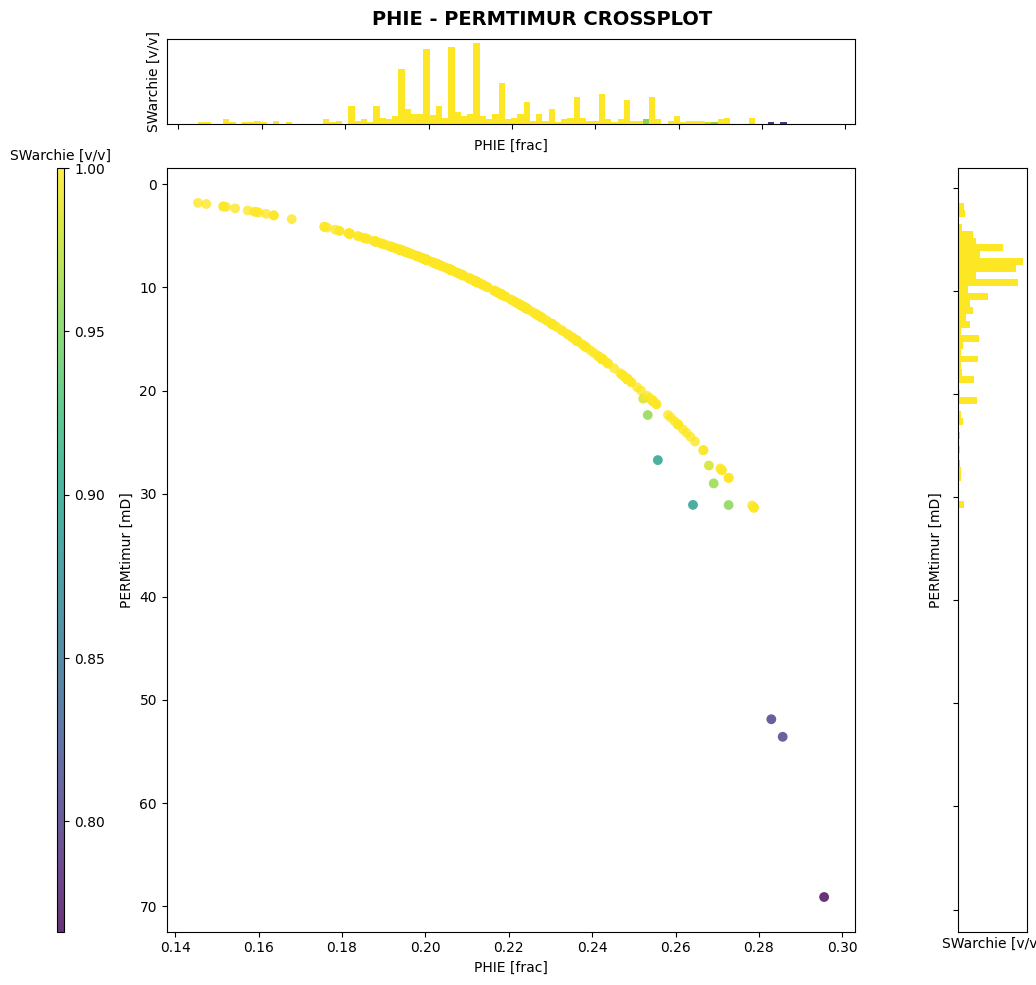

In [110]:
crossplott(logs,"PHIE","PERMtimur","SWarchie","frac","mD","v/v")